## Questa cella esegue il login su wandb

In [7]:
import wandb
from wandb import Api
import pandas as pd
import os
import shutil

# === CONFIGURAZIONE ===
sweeps_mapping = {
    "u5b163dg" : "YOLOv11s",
    "f82co65p": "YOLOv11n",
}

ENTITY = "pothole-detector"
PROJECT = "pothole-detector-NatureSR"

# === LOGIN ===
wandb.login(key="fd3c2f891b0f72499c0621ce15f0a8627a8dffa6")

# === SETUP ===
api = Api()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/lorenzo/.netrc


## Download dei dati da wandb

In [8]:
# === ESTRAZIONE DEI DATI ===
all_runs_data = []

summary_useful = [
    'lr/pg0', 
    'lr/pg1', 
    'lr/pg2', 
    'metrics/mAP50(B)', 
    'metrics/mAP50-95(B)', 
    'metrics/precision(B)', 
    'metrics/recall(B)', 
    'model/GFLOPs', 
    'model/parameters', 
    'model/speed_PyTorch(ms)', 
    'train/box_loss', 
    'train/cls_loss', 
    'train/dfl_loss',
    'val/box_loss',
    'val/cls_loss', 
    'val/dfl_loss',
]

# === CICLO SU TUTTI GLI SWEEP ===
# Carica sweep

OUTPUT_DIR = {sweep_id: f"results/{name}" for sweep_id, name in sweeps_mapping.items()}

for sweep_id in sweeps_mapping:
    out_dir = OUTPUT_DIR[sweep_id]
    os.makedirs(out_dir, exist_ok=True)
    print(f"\n📦 Sweep {sweep_id} → output in '{out_dir}'")
    
    try:
        sweep = api.sweep(f"{ENTITY}/{PROJECT}/{sweep_id}")
        runs = sweep.runs
        print(f"🔍 Trovati {len(runs)} run")
        
        for run in runs:
            run_id = run.id
            run_name = run.name or run_id
            found_files = []
            
            print(f"🔄 Analizzo run: {run_name}")
            
            # Elenca tutti gli artifacts del run
            artifacts = run.logged_artifacts()
            print(f"   📁 Trovati {len(artifacts)} artifacts")
            
            for artifact in artifacts:
                # Filtra solo gli artifacts che terminano con "_log"
                if not artifact.name.split(':')[0].endswith('_log'):
                    continue
                    
                print(f"   🔍 Controllo artifact: {artifact.name}")
                
                # Scarica l'artifact
                try:
                    artifact_dir = artifact.download()
                    print(f"   ⬇️ Scaricato in: {artifact_dir}")
                    
                    # Cerca results.csv in modo ricorsivo
                    for root, dirs, files in os.walk(artifact_dir):
                        for file in files:
                            if file == "results.csv":
                                results_path = os.path.join(root, file)
                                # Crea un nome file unico che include l'artifact
                                artifact_name_clean = artifact.name.replace(":", "_").replace("/", "_")
                                output_filename = f"{run_name}_{run_id}_{artifact_name_clean}_results.csv"
                                output_path = os.path.join(out_dir, output_filename)
                                
                                shutil.copy(results_path, output_path)
                                print(f"   ✅ Salvato: {output_path}")
                                found_files.append(output_path)
                                
                except Exception as e:
                    print(f"   ❌ Errore scaricando artifact {artifact.name}: {e}")
            
            if not found_files:
                print("   ⚠️ Nessun 'results.csv' trovato in nessun artifact.")
            else:
                print(f"   🎉 Trovati {len(found_files)} file results.csv")
                
    except Exception as e:
        print(f"❌ Errore nello sweep {sweep_id}: {e}")

print("\n🏁 Download completato!")


# === SALVATAGGIO COMPLETO ===
#df_all = pd.DataFrame(all_runs_data)
#df_all.to_csv(os.path.join(EXPORT_DIR, "sweep_results.csv"), index=False)
#print(f"\n📦 File completo salvato: sweep_results.csv con {len(df_all)} run")
#
## === STATISTICHE DESCRITTIVE GLOBALI ===
#desc = df_all.describe(include='all')
#desc.to_csv(os.path.join(EXPORT_DIR, "summary_statistics.csv"))
#print("📊 Statistiche descrittive salvate.")


📦 Sweep u5b163dg → output in 'results/YOLOv11s'
🔍 Trovati 15 run
🔄 Analizzo run: dandy-sweep-15
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v33


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v33
   ✅ Salvato: results/YOLOv11s/dandy-sweep-15_ndtylyj2_fold0_log_v33_results.csv
   🔍 Controllo artifact: fold1_log:v33


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v33
   ✅ Salvato: results/YOLOv11s/dandy-sweep-15_ndtylyj2_fold1_log_v33_results.csv
   🔍 Controllo artifact: fold2_log:v33


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v33
   ✅ Salvato: results/YOLOv11s/dandy-sweep-15_ndtylyj2_fold2_log_v33_results.csv
   🔍 Controllo artifact: fold3_log:v33


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v33
   ✅ Salvato: results/YOLOv11s/dandy-sweep-15_ndtylyj2_fold3_log_v33_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: twilight-sweep-14
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold1_log:v32


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v32
   ✅ Salvato: results/YOLOv11s/twilight-sweep-14_dhjbjm1m_fold1_log_v32_results.csv
   🔍 Controllo artifact: fold2_log:v32


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v32
   ✅ Salvato: results/YOLOv11s/twilight-sweep-14_dhjbjm1m_fold2_log_v32_results.csv
   🔍 Controllo artifact: fold3_log:v32


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v32
   ✅ Salvato: results/YOLOv11s/twilight-sweep-14_dhjbjm1m_fold3_log_v32_results.csv
   🔍 Controllo artifact: fold0_log:v32


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v32
   ✅ Salvato: results/YOLOv11s/twilight-sweep-14_dhjbjm1m_fold0_log_v32_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: cosmic-sweep-13
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v31


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v31
   ✅ Salvato: results/YOLOv11s/cosmic-sweep-13_wwwhn2dt_fold0_log_v31_results.csv
   🔍 Controllo artifact: fold1_log:v31


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v31
   ✅ Salvato: results/YOLOv11s/cosmic-sweep-13_wwwhn2dt_fold1_log_v31_results.csv
   🔍 Controllo artifact: fold2_log:v31


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v31
   ✅ Salvato: results/YOLOv11s/cosmic-sweep-13_wwwhn2dt_fold2_log_v31_results.csv
   🔍 Controllo artifact: fold3_log:v31


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v31
   ✅ Salvato: results/YOLOv11s/cosmic-sweep-13_wwwhn2dt_fold3_log_v31_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: clear-sweep-12
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v30


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v30
   ✅ Salvato: results/YOLOv11s/clear-sweep-12_nxy2giks_fold0_log_v30_results.csv
   🔍 Controllo artifact: fold1_log:v30


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v30
   ✅ Salvato: results/YOLOv11s/clear-sweep-12_nxy2giks_fold1_log_v30_results.csv
   🔍 Controllo artifact: fold2_log:v30


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v30
   ✅ Salvato: results/YOLOv11s/clear-sweep-12_nxy2giks_fold2_log_v30_results.csv
   🔍 Controllo artifact: fold3_log:v30


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v30
   ✅ Salvato: results/YOLOv11s/clear-sweep-12_nxy2giks_fold3_log_v30_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: pretty-sweep-11
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v29


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v29
   ✅ Salvato: results/YOLOv11s/pretty-sweep-11_qi9ggfkt_fold0_log_v29_results.csv
   🔍 Controllo artifact: fold1_log:v29


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v29
   ✅ Salvato: results/YOLOv11s/pretty-sweep-11_qi9ggfkt_fold1_log_v29_results.csv
   🔍 Controllo artifact: fold2_log:v29


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v29
   ✅ Salvato: results/YOLOv11s/pretty-sweep-11_qi9ggfkt_fold2_log_v29_results.csv
   🔍 Controllo artifact: fold3_log:v29


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v29
   ✅ Salvato: results/YOLOv11s/pretty-sweep-11_qi9ggfkt_fold3_log_v29_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: royal-sweep-10
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v28


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v28
   ✅ Salvato: results/YOLOv11s/royal-sweep-10_3baxdv6c_fold0_log_v28_results.csv
   🔍 Controllo artifact: fold1_log:v28


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v28
   ✅ Salvato: results/YOLOv11s/royal-sweep-10_3baxdv6c_fold1_log_v28_results.csv
   🔍 Controllo artifact: fold2_log:v28


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v28
   ✅ Salvato: results/YOLOv11s/royal-sweep-10_3baxdv6c_fold2_log_v28_results.csv
   🔍 Controllo artifact: fold3_log:v28


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v28
   ✅ Salvato: results/YOLOv11s/royal-sweep-10_3baxdv6c_fold3_log_v28_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: spring-sweep-9
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v27


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v27
   ✅ Salvato: results/YOLOv11s/spring-sweep-9_xd1zwqdv_fold0_log_v27_results.csv
   🔍 Controllo artifact: fold1_log:v27


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v27
   ✅ Salvato: results/YOLOv11s/spring-sweep-9_xd1zwqdv_fold1_log_v27_results.csv
   🔍 Controllo artifact: fold2_log:v27


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v27
   ✅ Salvato: results/YOLOv11s/spring-sweep-9_xd1zwqdv_fold2_log_v27_results.csv
   🔍 Controllo artifact: fold3_log:v27


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v27
   ✅ Salvato: results/YOLOv11s/spring-sweep-9_xd1zwqdv_fold3_log_v27_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: copper-sweep-8
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v26


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v26
   ✅ Salvato: results/YOLOv11s/copper-sweep-8_nyppd0jc_fold0_log_v26_results.csv
   🔍 Controllo artifact: fold1_log:v26


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v26
   ✅ Salvato: results/YOLOv11s/copper-sweep-8_nyppd0jc_fold1_log_v26_results.csv
   🔍 Controllo artifact: fold2_log:v26


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v26
   ✅ Salvato: results/YOLOv11s/copper-sweep-8_nyppd0jc_fold2_log_v26_results.csv
   🔍 Controllo artifact: fold3_log:v26


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v26
   ✅ Salvato: results/YOLOv11s/copper-sweep-8_nyppd0jc_fold3_log_v26_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: mild-sweep-7
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v25


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v25
   ✅ Salvato: results/YOLOv11s/mild-sweep-7_xme1syz0_fold0_log_v25_results.csv
   🔍 Controllo artifact: fold1_log:v25


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v25
   ✅ Salvato: results/YOLOv11s/mild-sweep-7_xme1syz0_fold1_log_v25_results.csv
   🔍 Controllo artifact: fold2_log:v25


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v25
   ✅ Salvato: results/YOLOv11s/mild-sweep-7_xme1syz0_fold2_log_v25_results.csv
   🔍 Controllo artifact: fold3_log:v25


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v25
   ✅ Salvato: results/YOLOv11s/mild-sweep-7_xme1syz0_fold3_log_v25_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: divine-sweep-6
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v24


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v24
   ✅ Salvato: results/YOLOv11s/divine-sweep-6_ijhpguhe_fold0_log_v24_results.csv
   🔍 Controllo artifact: fold1_log:v24


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v24
   ✅ Salvato: results/YOLOv11s/divine-sweep-6_ijhpguhe_fold1_log_v24_results.csv
   🔍 Controllo artifact: fold2_log:v24


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v24
   ✅ Salvato: results/YOLOv11s/divine-sweep-6_ijhpguhe_fold2_log_v24_results.csv
   🔍 Controllo artifact: fold3_log:v24


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v24
   ✅ Salvato: results/YOLOv11s/divine-sweep-6_ijhpguhe_fold3_log_v24_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: robust-sweep-5
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v23


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v23
   ✅ Salvato: results/YOLOv11s/robust-sweep-5_aux14hm1_fold0_log_v23_results.csv
   🔍 Controllo artifact: fold1_log:v23


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v23
   ✅ Salvato: results/YOLOv11s/robust-sweep-5_aux14hm1_fold1_log_v23_results.csv
   🔍 Controllo artifact: fold2_log:v23


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v23
   ✅ Salvato: results/YOLOv11s/robust-sweep-5_aux14hm1_fold2_log_v23_results.csv
   🔍 Controllo artifact: fold3_log:v23


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v23
   ✅ Salvato: results/YOLOv11s/robust-sweep-5_aux14hm1_fold3_log_v23_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: radiant-sweep-4
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v22


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v22
   ✅ Salvato: results/YOLOv11s/radiant-sweep-4_fiqbcygi_fold0_log_v22_results.csv
   🔍 Controllo artifact: fold2_log:v22


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v22
   ✅ Salvato: results/YOLOv11s/radiant-sweep-4_fiqbcygi_fold2_log_v22_results.csv
   🔍 Controllo artifact: fold1_log:v22


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v22
   ✅ Salvato: results/YOLOv11s/radiant-sweep-4_fiqbcygi_fold1_log_v22_results.csv
   🔍 Controllo artifact: fold3_log:v22


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v22
   ✅ Salvato: results/YOLOv11s/radiant-sweep-4_fiqbcygi_fold3_log_v22_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: mild-sweep-3
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v21


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v21
   ✅ Salvato: results/YOLOv11s/mild-sweep-3_a1gr1rnj_fold0_log_v21_results.csv
   🔍 Controllo artifact: fold1_log:v21


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v21
   ✅ Salvato: results/YOLOv11s/mild-sweep-3_a1gr1rnj_fold1_log_v21_results.csv
   🔍 Controllo artifact: fold2_log:v21


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v21
   ✅ Salvato: results/YOLOv11s/mild-sweep-3_a1gr1rnj_fold2_log_v21_results.csv
   🔍 Controllo artifact: fold3_log:v21


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v21
   ✅ Salvato: results/YOLOv11s/mild-sweep-3_a1gr1rnj_fold3_log_v21_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: dauntless-sweep-2
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v20


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v20
   ✅ Salvato: results/YOLOv11s/dauntless-sweep-2_cetgeypv_fold0_log_v20_results.csv
   🔍 Controllo artifact: fold1_log:v20


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v20
   ✅ Salvato: results/YOLOv11s/dauntless-sweep-2_cetgeypv_fold1_log_v20_results.csv
   🔍 Controllo artifact: fold2_log:v20


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v20
   ✅ Salvato: results/YOLOv11s/dauntless-sweep-2_cetgeypv_fold2_log_v20_results.csv
   🔍 Controllo artifact: fold3_log:v20


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v20
   ✅ Salvato: results/YOLOv11s/dauntless-sweep-2_cetgeypv_fold3_log_v20_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: blooming-sweep-1
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v19


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v19
   ✅ Salvato: results/YOLOv11s/blooming-sweep-1_f7zhibfd_fold0_log_v19_results.csv
   🔍 Controllo artifact: fold1_log:v19


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v19
   ✅ Salvato: results/YOLOv11s/blooming-sweep-1_f7zhibfd_fold1_log_v19_results.csv
   🔍 Controllo artifact: fold2_log:v19


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v19
   ✅ Salvato: results/YOLOv11s/blooming-sweep-1_f7zhibfd_fold2_log_v19_results.csv
   🔍 Controllo artifact: fold3_log:v19


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v19
   ✅ Salvato: results/YOLOv11s/blooming-sweep-1_f7zhibfd_fold3_log_v19_results.csv
   🎉 Trovati 4 file results.csv

📦 Sweep f82co65p → output in 'results/YOLOv11n'
🔍 Trovati 15 run
🔄 Analizzo run: rosy-sweep-15
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v14


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v14
   ✅ Salvato: results/YOLOv11n/rosy-sweep-15_lx7xg29f_fold0_log_v14_results.csv
   🔍 Controllo artifact: fold1_log:v14


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v14
   ✅ Salvato: results/YOLOv11n/rosy-sweep-15_lx7xg29f_fold1_log_v14_results.csv
   🔍 Controllo artifact: fold2_log:v14


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v14
   ✅ Salvato: results/YOLOv11n/rosy-sweep-15_lx7xg29f_fold2_log_v14_results.csv
   🔍 Controllo artifact: fold3_log:v14


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v14
   ✅ Salvato: results/YOLOv11n/rosy-sweep-15_lx7xg29f_fold3_log_v14_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: lyric-sweep-14
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v13


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v13
   ✅ Salvato: results/YOLOv11n/lyric-sweep-14_vbhhpdh3_fold0_log_v13_results.csv
   🔍 Controllo artifact: fold1_log:v13


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v13
   ✅ Salvato: results/YOLOv11n/lyric-sweep-14_vbhhpdh3_fold1_log_v13_results.csv
   🔍 Controllo artifact: fold2_log:v13


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v13
   ✅ Salvato: results/YOLOv11n/lyric-sweep-14_vbhhpdh3_fold2_log_v13_results.csv
   🔍 Controllo artifact: fold3_log:v13


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v13
   ✅ Salvato: results/YOLOv11n/lyric-sweep-14_vbhhpdh3_fold3_log_v13_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: vital-sweep-13
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v12


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v12
   ✅ Salvato: results/YOLOv11n/vital-sweep-13_at4gvmnc_fold0_log_v12_results.csv
   🔍 Controllo artifact: fold1_log:v12


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v12
   ✅ Salvato: results/YOLOv11n/vital-sweep-13_at4gvmnc_fold1_log_v12_results.csv
   🔍 Controllo artifact: fold2_log:v12


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v12
   ✅ Salvato: results/YOLOv11n/vital-sweep-13_at4gvmnc_fold2_log_v12_results.csv
   🔍 Controllo artifact: fold3_log:v12


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v12
   ✅ Salvato: results/YOLOv11n/vital-sweep-13_at4gvmnc_fold3_log_v12_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: vivid-sweep-12
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v11


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v11
   ✅ Salvato: results/YOLOv11n/vivid-sweep-12_boqn4ub0_fold0_log_v11_results.csv
   🔍 Controllo artifact: fold1_log:v11


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v11
   ✅ Salvato: results/YOLOv11n/vivid-sweep-12_boqn4ub0_fold1_log_v11_results.csv
   🔍 Controllo artifact: fold2_log:v11


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v11
   ✅ Salvato: results/YOLOv11n/vivid-sweep-12_boqn4ub0_fold2_log_v11_results.csv
   🔍 Controllo artifact: fold3_log:v11


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v11
   ✅ Salvato: results/YOLOv11n/vivid-sweep-12_boqn4ub0_fold3_log_v11_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: winter-sweep-11
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v10


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v10
   ✅ Salvato: results/YOLOv11n/winter-sweep-11_04tnxm1k_fold0_log_v10_results.csv
   🔍 Controllo artifact: fold1_log:v10


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v10
   ✅ Salvato: results/YOLOv11n/winter-sweep-11_04tnxm1k_fold1_log_v10_results.csv
   🔍 Controllo artifact: fold2_log:v10


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v10
   ✅ Salvato: results/YOLOv11n/winter-sweep-11_04tnxm1k_fold2_log_v10_results.csv
   🔍 Controllo artifact: fold3_log:v10


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v10
   ✅ Salvato: results/YOLOv11n/winter-sweep-11_04tnxm1k_fold3_log_v10_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: elated-sweep-10
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v9


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v9
   ✅ Salvato: results/YOLOv11n/elated-sweep-10_o1k85o6c_fold0_log_v9_results.csv
   🔍 Controllo artifact: fold1_log:v9


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v9
   ✅ Salvato: results/YOLOv11n/elated-sweep-10_o1k85o6c_fold1_log_v9_results.csv
   🔍 Controllo artifact: fold2_log:v9


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v9
   ✅ Salvato: results/YOLOv11n/elated-sweep-10_o1k85o6c_fold2_log_v9_results.csv
   🔍 Controllo artifact: fold3_log:v9


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v9
   ✅ Salvato: results/YOLOv11n/elated-sweep-10_o1k85o6c_fold3_log_v9_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: dainty-sweep-9
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v8


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v8
   ✅ Salvato: results/YOLOv11n/dainty-sweep-9_fuv6z94d_fold0_log_v8_results.csv
   🔍 Controllo artifact: fold1_log:v8


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v8
   ✅ Salvato: results/YOLOv11n/dainty-sweep-9_fuv6z94d_fold1_log_v8_results.csv
   🔍 Controllo artifact: fold2_log:v8


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v8
   ✅ Salvato: results/YOLOv11n/dainty-sweep-9_fuv6z94d_fold2_log_v8_results.csv
   🔍 Controllo artifact: fold3_log:v8


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v8
   ✅ Salvato: results/YOLOv11n/dainty-sweep-9_fuv6z94d_fold3_log_v8_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: worthy-sweep-8
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v7


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v7
   ✅ Salvato: results/YOLOv11n/worthy-sweep-8_d1j8qdb2_fold0_log_v7_results.csv
   🔍 Controllo artifact: fold1_log:v7


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v7
   ✅ Salvato: results/YOLOv11n/worthy-sweep-8_d1j8qdb2_fold1_log_v7_results.csv
   🔍 Controllo artifact: fold2_log:v7


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v7
   ✅ Salvato: results/YOLOv11n/worthy-sweep-8_d1j8qdb2_fold2_log_v7_results.csv
   🔍 Controllo artifact: fold3_log:v7


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v7
   ✅ Salvato: results/YOLOv11n/worthy-sweep-8_d1j8qdb2_fold3_log_v7_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: logical-sweep-7
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v6


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v6
   ✅ Salvato: results/YOLOv11n/logical-sweep-7_0y4niaq4_fold0_log_v6_results.csv
   🔍 Controllo artifact: fold1_log:v6


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v6
   ✅ Salvato: results/YOLOv11n/logical-sweep-7_0y4niaq4_fold1_log_v6_results.csv
   🔍 Controllo artifact: fold2_log:v6


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v6
   ✅ Salvato: results/YOLOv11n/logical-sweep-7_0y4niaq4_fold2_log_v6_results.csv
   🔍 Controllo artifact: fold3_log:v6


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v6
   ✅ Salvato: results/YOLOv11n/logical-sweep-7_0y4niaq4_fold3_log_v6_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: dandy-sweep-6
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v5


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v5
   ✅ Salvato: results/YOLOv11n/dandy-sweep-6_d7xme7yu_fold0_log_v5_results.csv
   🔍 Controllo artifact: fold1_log:v5


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v5
   ✅ Salvato: results/YOLOv11n/dandy-sweep-6_d7xme7yu_fold1_log_v5_results.csv
   🔍 Controllo artifact: fold2_log:v5


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v5
   ✅ Salvato: results/YOLOv11n/dandy-sweep-6_d7xme7yu_fold2_log_v5_results.csv
   🔍 Controllo artifact: fold3_log:v5


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v5
   ✅ Salvato: results/YOLOv11n/dandy-sweep-6_d7xme7yu_fold3_log_v5_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: super-sweep-5
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v4


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v4
   ✅ Salvato: results/YOLOv11n/super-sweep-5_h5layrxy_fold0_log_v4_results.csv
   🔍 Controllo artifact: fold1_log:v4


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v4
   ✅ Salvato: results/YOLOv11n/super-sweep-5_h5layrxy_fold1_log_v4_results.csv
   🔍 Controllo artifact: fold2_log:v4


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v4
   ✅ Salvato: results/YOLOv11n/super-sweep-5_h5layrxy_fold2_log_v4_results.csv
   🔍 Controllo artifact: fold3_log:v4


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v4
   ✅ Salvato: results/YOLOv11n/super-sweep-5_h5layrxy_fold3_log_v4_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: misunderstood-sweep-4
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v3


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v3
   ✅ Salvato: results/YOLOv11n/misunderstood-sweep-4_8i8zwhqk_fold0_log_v3_results.csv
   🔍 Controllo artifact: fold1_log:v3


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v3
   ✅ Salvato: results/YOLOv11n/misunderstood-sweep-4_8i8zwhqk_fold1_log_v3_results.csv
   🔍 Controllo artifact: fold2_log:v3


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v3
   ✅ Salvato: results/YOLOv11n/misunderstood-sweep-4_8i8zwhqk_fold2_log_v3_results.csv
   🔍 Controllo artifact: fold3_log:v3


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v3
   ✅ Salvato: results/YOLOv11n/misunderstood-sweep-4_8i8zwhqk_fold3_log_v3_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: fearless-sweep-3
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v2


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v2
   ✅ Salvato: results/YOLOv11n/fearless-sweep-3_b7dei5to_fold0_log_v2_results.csv
   🔍 Controllo artifact: fold1_log:v2


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v2
   ✅ Salvato: results/YOLOv11n/fearless-sweep-3_b7dei5to_fold1_log_v2_results.csv
   🔍 Controllo artifact: fold2_log:v2


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v2
   ✅ Salvato: results/YOLOv11n/fearless-sweep-3_b7dei5to_fold2_log_v2_results.csv
   🔍 Controllo artifact: fold3_log:v2


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v2
   ✅ Salvato: results/YOLOv11n/fearless-sweep-3_b7dei5to_fold3_log_v2_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: logical-sweep-2
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v1


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v1
   ✅ Salvato: results/YOLOv11n/logical-sweep-2_nexrfefx_fold0_log_v1_results.csv
   🔍 Controllo artifact: fold1_log:v1


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v1
   ✅ Salvato: results/YOLOv11n/logical-sweep-2_nexrfefx_fold1_log_v1_results.csv
   🔍 Controllo artifact: fold2_log:v1


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v1
   ✅ Salvato: results/YOLOv11n/logical-sweep-2_nexrfefx_fold2_log_v1_results.csv
   🔍 Controllo artifact: fold3_log:v1


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v1
   ✅ Salvato: results/YOLOv11n/logical-sweep-2_nexrfefx_fold3_log_v1_results.csv
   🎉 Trovati 4 file results.csv
🔄 Analizzo run: sparkling-sweep-1
   📁 Trovati 5 artifacts
   🔍 Controllo artifact: fold0_log:v0


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold0_log:v0
   ✅ Salvato: results/YOLOv11n/sparkling-sweep-1_zepjk15r_fold0_log_v0_results.csv
   🔍 Controllo artifact: fold1_log:v0


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold1_log:v0
   ✅ Salvato: results/YOLOv11n/sparkling-sweep-1_zepjk15r_fold1_log_v0_results.csv
   🔍 Controllo artifact: fold2_log:v0


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold2_log:v0
   ✅ Salvato: results/YOLOv11n/sparkling-sweep-1_zepjk15r_fold2_log_v0_results.csv
   🔍 Controllo artifact: fold3_log:v0


wandb:   1 of 1 files downloaded.  


   ⬇️ Scaricato in: /home/lorenzo/Documenti/GitHub/Computer-Science-Sapienza/Computer Vision/project/artifacts/fold3_log:v0
   ✅ Salvato: results/YOLOv11n/sparkling-sweep-1_zepjk15r_fold3_log_v0_results.csv
   🎉 Trovati 4 file results.csv

🏁 Download completato!


In [9]:
import pandas as pd
import os
import re
from pathlib import Path

def load_all_results_to_dataframe(base_directory="results"):
    """
    Carica tutti i CSV dai risultati degli sweep in un singolo DataFrame.
    
    Args:
        base_directory: Directory base contenente le cartelle dei modelli
    
    Returns:
        pandas.DataFrame: DataFrame combinato con tutti i risultati
    """
    
    all_data = []
    
    # Scorri tutte le directory dei modelli
    for model_dir in os.listdir(base_directory):
        model_path = os.path.join(base_directory, model_dir)
        
        if not os.path.isdir(model_path):
            continue
            
        print(f"🔍 Processando modello: {model_dir}")
        
        # Scorri tutti i file CSV nella directory del modello
        csv_files = [f for f in os.listdir(model_path) if f.endswith('.csv')]
        print(f"   📁 Trovati {len(csv_files)} file CSV")
        
        for csv_file in csv_files:
            # Estrai informazioni dal nome del file
            # Formato: nome-sweep-X_codice_foldY_log_vZ_results.csv
            match = re.match(r'(.+?)_([a-z0-9]+)_(fold\d+)_log_v\d+_results\.csv', csv_file)
            
            if not match:
                print(f"   ⚠️ Formato nome file non riconosciuto: {csv_file}")
                continue
                
            run_name = match.group(1)
            run_code = match.group(2)
            fold = match.group(3)
            
            # Carica il CSV
            csv_path = os.path.join(model_path, csv_file)
            try:
                df = pd.read_csv(csv_path)
                
                # Aggiungi le colonne identificative
                df['model'] = model_dir
                df['run_name'] = run_name
                df['run_code'] = run_code
                df['fold'] = fold
                df['fold_number'] = int(fold.replace('fold', ''))
                
                # Aggiungi alla lista
                all_data.append(df)
                
                print(f"   ✅ Caricato: {csv_file} ({len(df)} righe)")
                
            except Exception as e:
                print(f"   ❌ Errore caricando {csv_file}: {e}")
    
    if not all_data:
        print("❌ Nessun dato trovato!")
        return pd.DataFrame()
    
    # Combina tutti i DataFrame
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Riordina le colonne mettendo le identificative all'inizio
    id_columns = ['model', 'run_name', 'run_code', 'fold', 'fold_number']
    other_columns = [col for col in combined_df.columns if col not in id_columns]
    combined_df = combined_df[id_columns + other_columns]
    
    print(f"\n🎉 DataFrame combinato creato!")
    print(f"   📊 Totale righe: {len(combined_df)}")
    print(f"   📈 Modelli: {combined_df['model'].nunique()}")
    print(f"   🏃 Run unici: {combined_df['run_code'].nunique()}")
    print(f"   📂 Fold: {sorted(combined_df['fold'].unique())}")
    
    return combined_df

def get_summary_statistics(df):
    """
    Genera statistiche riassuntive del dataset.
    
    Args:
        df: DataFrame combinato
    
    Returns:
        dict: Dizionario con statistiche
    """
    
    summary = {
        'total_rows': len(df),
        'total_models': df['model'].nunique(),
        'total_runs': df['run_code'].nunique(),
        'models_list': df['model'].unique().tolist(),
        'runs_per_model': df.groupby('model')['run_code'].nunique().to_dict(),
        'epochs_per_run_fold': df.groupby(['run_code', 'fold'])['epoch'].count().describe(),
        'max_epochs': df.groupby(['run_code', 'fold'])['epoch'].max().describe()
    }
    
    return summary

# Esempio di utilizzo
if __name__ == "__main__":
    # Carica tutti i dati
    df = load_all_results_to_dataframe("results")
    
    if not df.empty:
        # Mostra informazioni base
        print(f"\n📋 Struttura DataFrame:")
        print(f"   Shape: {df.shape}")
        print(f"   Colonne: {list(df.columns)}")
        
        # Mostra alcuni esempi
        print(f"\n🔍 Prime 5 righe:")
        print(df.head())

        # Statistiche riassuntive
        print(f"\n📊 Statistiche per modello:")
        print(df.groupby(['model', 'run_name', 'fold']).size().head(10))
        
        # Salva il DataFrame combinato
        output_path = "combined_results.csv"
        df.to_csv(output_path, index=False)
        print(f"\n💾 DataFrame salvato in: {output_path}")
        
        # Genera statistiche
        stats = get_summary_statistics(df)
        print(f"\n📈 Statistiche riassuntive:")
        for key, value in stats.items():
            if key != 'epochs_per_run_fold' and key != 'max_epochs':
                print(f"   {key}: {value}")

🔍 Processando modello: YOLOv8n
   📁 Trovati 0 file CSV
🔍 Processando modello: MobileNetv3-SSD320
   📁 Trovati 0 file CSV
🔍 Processando modello: YOLOv11s
   📁 Trovati 60 file CSV
   ✅ Caricato: mild-sweep-7_xme1syz0_fold2_log_v25_results.csv (36 righe)
   ✅ Caricato: robust-sweep-5_aux14hm1_fold0_log_v23_results.csv (33 righe)
   ✅ Caricato: dauntless-sweep-2_cetgeypv_fold1_log_v20_results.csv (89 righe)
   ✅ Caricato: radiant-sweep-4_fiqbcygi_fold3_log_v22_results.csv (100 righe)
   ✅ Caricato: spring-sweep-9_xd1zwqdv_fold2_log_v27_results.csv (53 righe)
   ✅ Caricato: cosmic-sweep-13_wwwhn2dt_fold3_log_v31_results.csv (64 righe)
   ✅ Caricato: clear-sweep-12_nxy2giks_fold3_log_v30_results.csv (76 righe)
   ✅ Caricato: divine-sweep-6_ijhpguhe_fold1_log_v24_results.csv (70 righe)
   ✅ Caricato: mild-sweep-7_xme1syz0_fold1_log_v25_results.csv (41 righe)
   ✅ Caricato: dandy-sweep-15_ndtylyj2_fold0_log_v33_results.csv (76 righe)
   ✅ Caricato: twilight-sweep-14_dhjbjm1m_fold3_log_v32_resu

In [12]:
df.head()

,model,run_name,run_code,fold,fold_number,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,YOLOv11s,mild-sweep-7,xme1syz0,fold2,2,1,46.4592,2.72694,4.52210,2.15230,0.22573,0.26301,0.17244,0.06604,2.27710,2.75805,1.92955,0.067692,0.000675,0.000675
1,YOLOv11s,mild-sweep-7,xme1syz0,fold2,2,2,88.9148,2.19113,2.51462,1.72669,0.39104,0.36855,0.30939,0.12441,2.13945,2.16566,1.70957,0.035028,0.001344,0.001344
2,YOLOv11s,mild-sweep-7,xme1syz0,fold2,2,3,128.9730,2.09919,2.19434,1.59893,0.35499,0.36924,0.32760,0.13290,2.12736,2.17802,1.66327,0.002351,0.002001,0.002001
3,YOLOv11s,mild-sweep-7,xme1syz0,fold2,2,4,168.5210,2.05871,2.04827,1.54058,0.41690,0.39079,0.35644,0.15300,2.08124,2.04832,1.59599,0.001989,0.001989,0.001989
4,YOLOv11s,mild-sweep-7,xme1syz0,fold2,2,5,210.1230,1.99023,1.92364,1.49452,0.45971,0.43883,0.41268,0.17295,2.04582,2.00632,1.56913,0.001970,0.001970,0.001970


## Analisi esplorativa dei dati degli sweeps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Configurazione grafici
plt.style.use('default')
sns.set_palette("husl")
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Imposta Pandas per mostrare tutte le colonne
pd.set_option('display.max_columns', 200)

# Configurazione costanti
EXPORT_DIR = "wandb_sweep_analysis"

# Lettura del file TSV
print("📊 Caricamento dati...")
df = pd.read_csv(EXPORT_DIR + '/sweep_results.csv')  # Modifica il path
print(f"✅ Dati caricati: {df.shape[0]} runs, {df.shape[1]} colonne")

print("\n" + "="*80)
print("🔍 ANALISI HYPERPARAMETER SWEEP - YOLO11n & YOLO12n")
print("="*80)

📊 Caricamento dati...
✅ Dati caricati: 107 runs, 125 colonne

🔍 ANALISI HYPERPARAMETER SWEEP - YOLO11n & YOLO12n


In [2]:
df.head()

,run_id,name,state,sweep_name,amp,bgr,box,cfg,cls,dfl,dnn,iou,lr0,lrf,nbs,nms,val,conf,data,half,int8,kobj,mode,pose,rect,save,seed,show,task,time,batch,cache,embed,hsv_h,hsv_s,hsv_v,imgsz,keras,mixup,model,opset,plots,scale,shear,split,cos_lr,device,epochs,fliplr,flipud,format,freeze,mosaic,resume,source,augment,classes,degrees,dropout,dynamic,erasing,max_det,profile,project,tracker,verbose,workers,exist_ok,fraction,momentum,optimize,patience,save_dir,save_txt,simplify,optimizer,save_conf,save_crop,save_json,show_conf,translate,visualize,workspace,copy_paste,line_width,mask_ratio,pretrained,show_boxes,single_cls,vid_stride,multi_scale,perspective,save_frames,save_hybrid,save_period,show_labels,agnostic_nms,auto_augment,close_mosaic,overlap_mask,retina_masks,weight_decay,crop_fraction,deterministic,stream_buffer,warmup_epochs,warmup_bias_lr,copy_paste_mode,warmup_momentum,lr/pg0,lr/pg1,lr/pg2,metrics/mAP50(B),metrics/mAP50-95(B),metrics/precision(B),metrics/recall(B),model/GFLOPs,model/parameters,model/speed_PyTorch(ms),train/box_loss,train/cls_loss,train/dfl_loss,val/box_loss,val/cls_loss,val/dfl_loss
0,rj3vkboi,sweep-run,finished,smn1s1kt,True,0,7.5,NaN,0.5,1.5,False,0.7,0.005411,0.033000,64,False,True,NaN,/kaggle/input/pothole-test/data/data.yaml,False,False,1,train,12,False,True,0,False,detect,NaN,16,False,NaN,0.015,0.7,0.4,640,False,0,yolo11n.pt,NaN,True,0.5,0,val,False,0,100,0.5,0,torchscript,NaN,1,False,NaN,False,NaN,0,0.145178,False,0.4,300,False,yolo-training,botsort.yaml,True,8,True,1,0.948983,False,100,yolo-training/sweep-run,False,True,AdamW,False,False,False,True,0.1,False,NaN,0,NaN,4,True,True,False,1,False,0,False,False,-1,True,False,randaugment,10,True,False,0.008749,1,True,False,3,0.1,flip,0.8,0.000231,0.000231,0.000231,0.554692,0.264240,0.554926,0.528094,6.443,2590425,2.621,1.74137,1.49319,1.45248,1.92138,1.86112,1.63289
1,e8a4gklw,sweep-run,finished,smn1s1kt,True,0,7.5,NaN,0.5,1.5,False,0.7,0.006098,0.011039,64,False,True,NaN,/kaggle/input/pothole-test/data/data.yaml,False,False,1,train,12,False,True,0,False,detect,NaN,8,False,NaN,0.015,0.7,0.4,640,False,0,yolo11n.pt,NaN,True,0.5,0,val,False,0,100,0.5,0,torchscript,NaN,1,False,NaN,False,NaN,0,0.161820,False,0.4,300,False,yolo-training,botsort.yaml,True,8,True,1,0.836918,False,100,yolo-training/sweep-run,False,True,SGD,False,False,False,True,0.1,False,NaN,0,NaN,4,True,True,False,1,False,0,False,False,-1,True,False,randaugment,10,True,False,0.008664,1,True,False,3,0.1,flip,0.8,0.000128,0.000128,0.000128,0.608346,0.304499,0.692221,0.533635,6.443,2590425,2.576,1.38341,1.05118,1.15417,1.95964,1.73547,1.50513
2,mhpya045,sweep-run,finished,smn1s1kt,True,0,7.5,NaN,0.5,1.5,False,0.7,0.007792,0.051823,64,False,True,NaN,/kaggle/input/pothole-test/data/data.yaml,False,False,1,train,12,False,True,0,False,detect,NaN,16,False,NaN,0.015,0.7,0.4,640,False,0,yolo11n.pt,NaN,True,0.5,0,val,False,0,100,0.5,0,torchscript,NaN,1,False,NaN,False,NaN,0,0.006292,False,0.4,300,False,yolo-training,botsort.yaml,True,8,True,1,0.403599,False,100,yolo-training/sweep-run,False,True,SGD,False,False,False,True,0.1,False,NaN,0,NaN,4,True,True,False,1,False,0,False,False,-1,True,False,randaugment,10,True,False,0.009633,1,True,False,3,0.1,flip,0.8,0.000478,0.000478,0.000478,0.575417,0.289958,0.626047,0.560626,6.443,2590425,2.625,1.52408,1.39041,1.21978,1.93130,1.88310,1.47185
3,ae9d5mf6,sweep-run,finished,smn1s1kt,True,0,7.5,NaN,0.5,1.5,False,0.7,0.006055,0.074576,64,False,True,NaN,/kaggle/input/pothole-test/data/data.yaml,False,False,1,train,12,False,True,0,False,detect,NaN,8,False,NaN,0.015,0.7,0.4,640,False,0,yolo11n.pt,NaN,True,0.5,0,val,False,0,100,0.5,0,torchscript,NaN,1,False,NaN,False,NaN,0,0.195787,False,0.4,300,False,yolo-training,botsort.yaml,True,8,True,1,0.431759,False,100,yolo-training/sweep-run,False,True,SGD,False,False,False,True,0.1,False,NaN,0,NaN,4,True,True,False,1,False,0,False,False,-1,True,False,randaugment,10,True,False,0.004902,1,True,False,3,0.1,flip,0.8,0.000508,0.0005

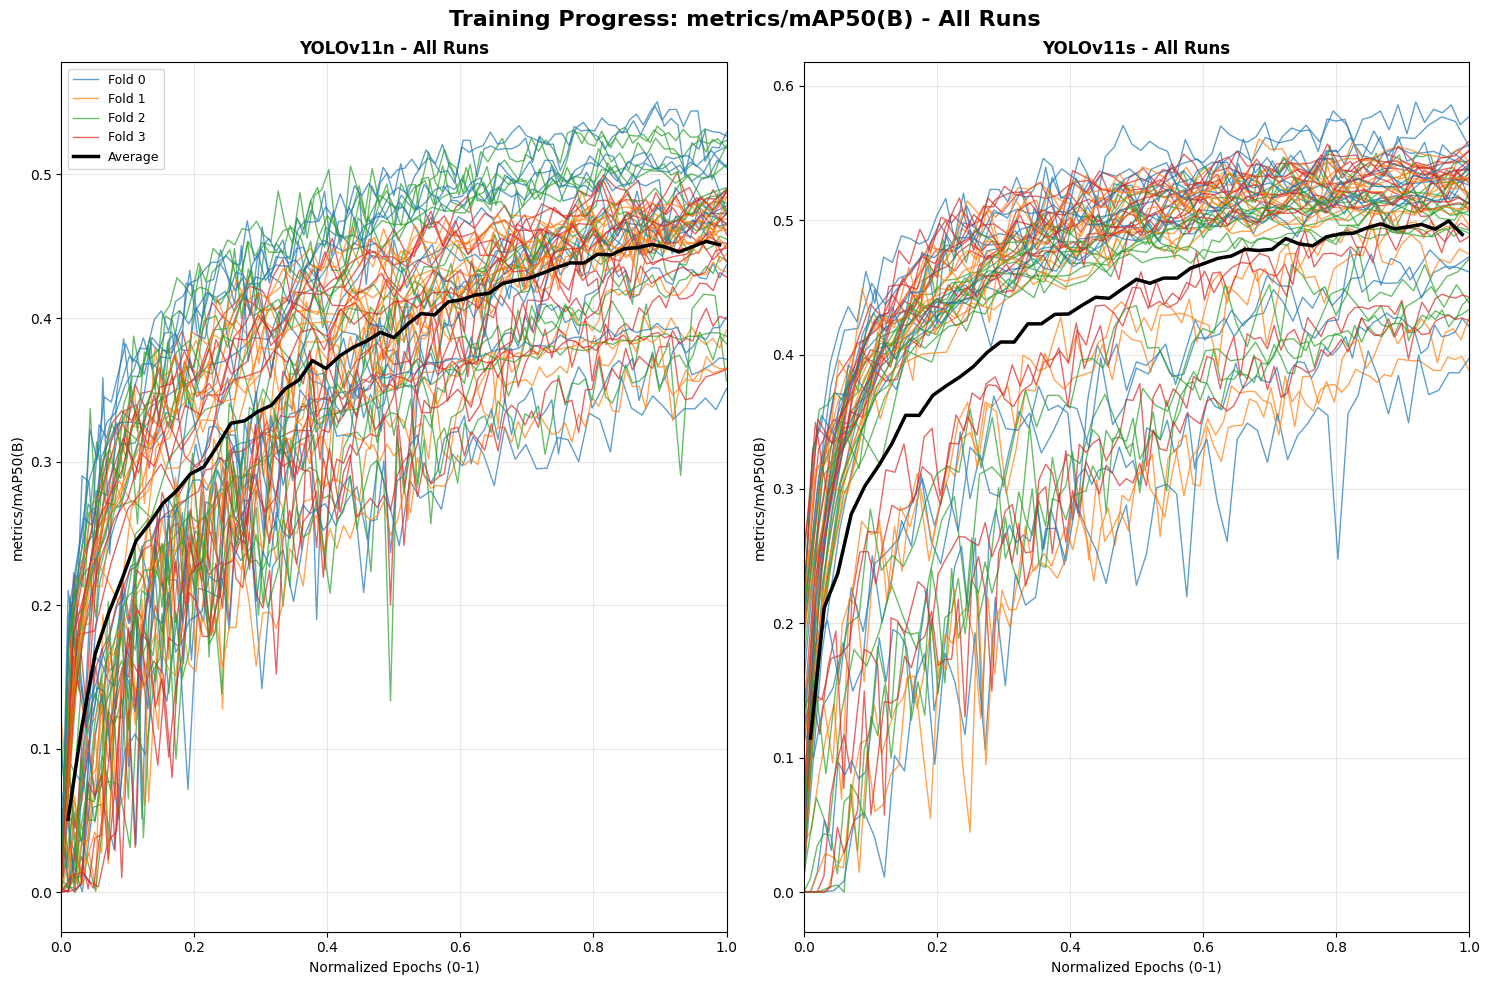

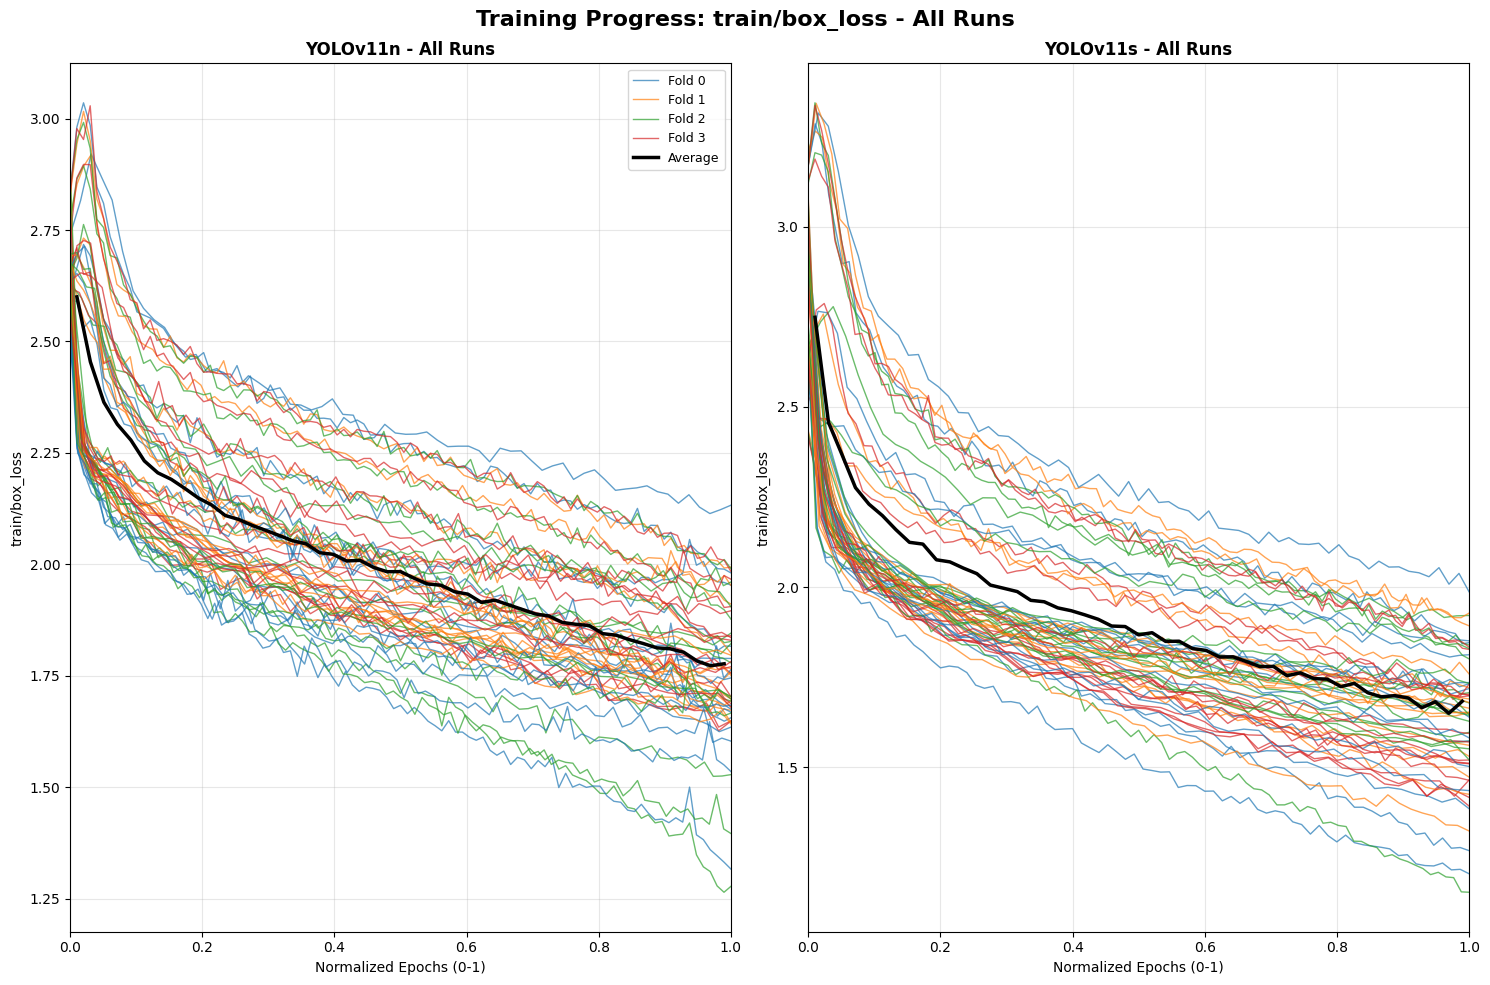

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

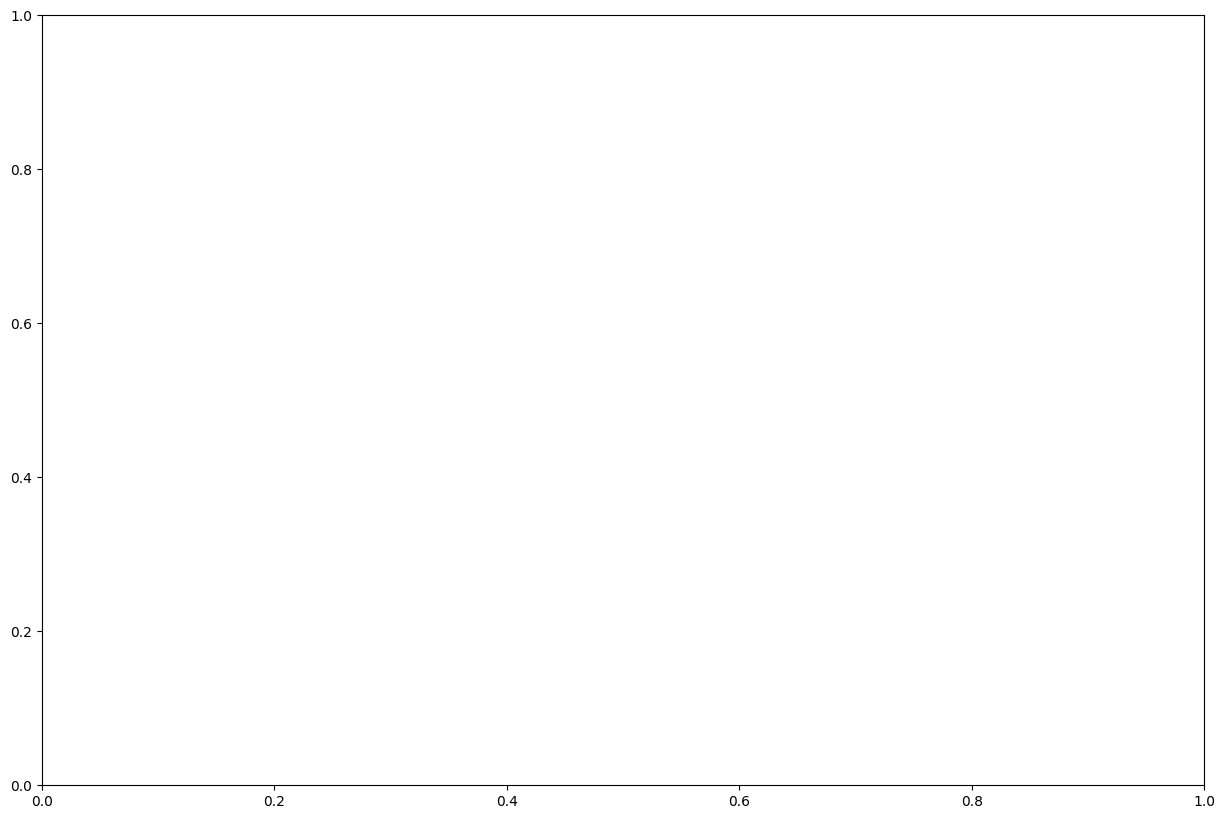

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import to_rgba
import seaborn as sns

def plot_metric_by_model(df, metric_column, run_code=None, figsize=(15, 10), save_path=None):
    """
    Crea subplot per ogni modello mostrando l'andamento di una metrica per fold.
    
    Args:
        df: DataFrame combinato
        metric_column: Nome della colonna metrica da plottare
        run_code: Se specificato, filtra solo per questo run. Se None, usa tutti i run
        figsize: Dimensione della figura
        save_path: Percorso per salvare il plot (opzionale)
    """
    
    # Filtra per run specifico se richiesto
    if run_code:
        df_filtered = df[df['run_code'] == run_code].copy()
        title_suffix = f" - Run: {run_code}"
    else:
        df_filtered = df.copy()
        title_suffix = " - All Runs"
    
    # Verifica che la metrica esista
    if metric_column not in df_filtered.columns:
        print(f"❌ Metrica '{metric_column}' non trovata nel DataFrame")
        return
    
    # Ottieni i modelli unici
    models = sorted(df_filtered['model'].unique())
    
    # Calcola dimensioni subplot
    n_models = len(models)
    cols = min(3, n_models)  # Massimo 3 colonne
    rows = (n_models + cols - 1) // cols
    
    # Crea la figura
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Gestisci il caso di un singolo subplot
    if n_models == 1:
        axes = np.array([axes])
    elif rows == 1 and cols > 1:
        axes = axes.reshape(1, -1)
    elif rows > 1 and cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Assicurati che axes sia sempre 2D
    if axes.ndim == 1:
        axes = axes.reshape(1, -1)
    
    # Colori per i fold (desaturati)
    fold_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colori base
    fold_colors_desat = [to_rgba(color, alpha=0.6) for color in fold_colors]  # Versione desaturata
    
    for idx, model in enumerate(models):
        row = idx // cols
        col = idx % cols
        
        # Gestisci l'accesso all'asse corretto
        if rows == 1 and cols == 1:
            ax = axes[0]
        elif rows == 1:
            ax = axes[0, col]
        elif cols == 1:
            ax = axes[row, 0]
        else:
            ax = axes[row, col]
        
        model_data = df_filtered[df_filtered['model'] == model]
        
        if model_data.empty:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{model} - No Data')
            continue
        
        # Per ogni run nel modello
        runs = model_data['run_code'].unique()
        
        # Prepara dati per la media
        all_normalized_data = []
        
        for run in runs:
            run_data = model_data[model_data['run_code'] == run]
            
            # Plot per ogni fold
            for fold_num in range(4):
                fold_data = run_data[run_data['fold_number'] == fold_num]
                
                if fold_data.empty:
                    continue
                
                # Normalizza le epoche tra 0 e 1
                epochs = fold_data['epoch'].values
                if len(epochs) > 1:
                    normalized_epochs = (epochs - epochs.min()) / (epochs.max() - epochs.min())
                else:
                    normalized_epochs = np.array([0])  # Se c'è solo un'epoca
                
                metric_values = fold_data[metric_column].values
                
                # Plot della linea del fold (desaturata)
                ax.plot(normalized_epochs, metric_values, 
                       color=fold_colors_desat[fold_num], 
                       linewidth=1, 
                       alpha=0.7,
                       label=f'Fold {fold_num}' if run == runs[0] else "")
                
                # Salva per calcolare la media
                for i, (norm_epoch, value) in enumerate(zip(normalized_epochs, metric_values)):
                    all_normalized_data.append({
                        'normalized_epoch': norm_epoch,
                        'metric_value': value,
                        'fold': fold_num,
                        'run': run
                    })
        
        # Calcola e plotta la media
        if all_normalized_data:
            avg_data = pd.DataFrame(all_normalized_data)
            
            # Crea bins per le epoche normalizzate per calcolare la media
            n_bins = 50
            epoch_bins = np.linspace(0, 1, n_bins)
            bin_centers = []
            bin_means = []
            
            for i in range(len(epoch_bins) - 1):
                bin_start, bin_end = epoch_bins[i], epoch_bins[i + 1]
                bin_data = avg_data[
                    (avg_data['normalized_epoch'] >= bin_start) & 
                    (avg_data['normalized_epoch'] < bin_end)
                ]
                
                if not bin_data.empty:
                    bin_centers.append((bin_start + bin_end) / 2)
                    bin_means.append(bin_data['metric_value'].mean())
            
            # Plot della media (colore saturo)
            if bin_centers:
                ax.plot(bin_centers, bin_means, 
                       color='black', 
                       linewidth=2.5, 
                       label='Average', 
                       zorder=10)
        
        # Personalizzazione del subplot
        ax.set_title(f'{model}{title_suffix}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Normalized Epochs (0-1)', fontsize=10)
        ax.set_ylabel(metric_column, fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        
        # Legenda solo per il primo subplot
        if idx == 0:
            ax.legend(loc='best', fontsize=9)
    
    # Nascondi subplot vuoti
    for idx in range(n_models, rows * cols):
        row = idx // cols
        col = idx % cols
        
        # Gestisci l'accesso all'asse per nasconderlo
        if rows == 1 and cols == 1:
            continue  # Non c'è niente da nascondere
        elif rows == 1:
            axes[0, col].set_visible(False)
        elif cols == 1:
            axes[row, 0].set_visible(False)
        else:
            axes[row, col].set_visible(False)
    
    # Titolo generale
    plt.suptitle(f'Training Progress: {metric_column}{title_suffix}', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Plot salvato in: {save_path}")
    
    plt.show()

def plot_single_model_all_runs(df, model_name, metric_column, figsize=(12, 8), save_path=None):
    """
    Crea un plot per un singolo modello mostrando tutti i run separatamente.
    
    Args:
        df: DataFrame combinato
        model_name: Nome del modello da plottare
        metric_column: Nome della colonna metrica da plottare
        figsize: Dimensione della figura
        save_path: Percorso per salvare il plot (opzionale)
    """
    
    model_data = df[df['model'] == model_name]
    
    if model_data.empty:
        print(f"❌ Nessun dato trovato per il modello {model_name}")
        return
    
    runs = sorted(model_data['run_code'].unique())
    n_runs = len(runs)
    
    # Calcola dimensioni subplot
    cols = min(3, n_runs)
    rows = (n_runs + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Gestisci il caso di un singolo subplot
    if n_runs == 1:
        axes = np.array([axes])
    elif rows == 1 and cols > 1:
        axes = axes.reshape(1, -1)
    elif rows > 1 and cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Assicurati che axes sia sempre 2D
    if axes.ndim == 1:
        axes = axes.reshape(1, -1)
    
    fold_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    fold_colors_desat = [to_rgba(color, alpha=0.6) for color in fold_colors]
    
    for idx, run in enumerate(runs):
        row = idx // cols
        col = idx % cols
        
        # Gestisci l'accesso all'asse corretto
        if rows == 1 and cols == 1:
            ax = axes[0]
        elif rows == 1:
            ax = axes[0, col]
        elif cols == 1:
            ax = axes[row, 0]
        else:
            ax = axes[row, col]
        
        run_data = model_data[model_data['run_code'] == run]
        run_name = run_data['run_name'].iloc[0]
        
        all_normalized_data = []
        
        # Plot per ogni fold
        for fold_num in range(4):
            fold_data = run_data[run_data['fold_number'] == fold_num]
            
            if fold_data.empty:
                continue
            
            epochs = fold_data['epoch'].values
            if len(epochs) > 1:
                normalized_epochs = (epochs - epochs.min()) / (epochs.max() - epochs.min())
            else:
                normalized_epochs = np.array([0])
            
            metric_values = fold_data[metric_column].values
            
            ax.plot(normalized_epochs, metric_values, 
                   color=fold_colors_desat[fold_num], 
                   linewidth=1, 
                   alpha=0.7,
                   label=f'Fold {fold_num}' if idx == 0 else "")
            
            for norm_epoch, value in zip(normalized_epochs, metric_values):
                all_normalized_data.append({
                    'normalized_epoch': norm_epoch,
                    'metric_value': value
                })
        
        # Media
        if all_normalized_data:
            avg_data = pd.DataFrame(all_normalized_data)
            n_bins = 30
            epoch_bins = np.linspace(0, 1, n_bins)
            bin_centers = []
            bin_means = []
            
            for i in range(len(epoch_bins) - 1):
                bin_start, bin_end = epoch_bins[i], epoch_bins[i + 1]
                bin_data = avg_data[
                    (avg_data['normalized_epoch'] >= bin_start) & 
                    (avg_data['normalized_epoch'] < bin_end)
                ]
                
                if not bin_data.empty:
                    bin_centers.append((bin_start + bin_end) / 2)
                    bin_means.append(bin_data['metric_value'].mean())
            
            if bin_centers:
                ax.plot(bin_centers, bin_means, 
                       color='black', 
                       linewidth=2, 
                       label='Average' if idx == 0 else "", 
                       zorder=10)
        
        ax.set_title(f'{run_name} ({run})', fontsize=10)
        ax.set_xlabel('Normalized Epochs')
        ax.set_ylabel(metric_column)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        
        if idx == 0:
            ax.legend(loc='best', fontsize=8)
    
    # Nascondi subplot vuoti
    for idx in range(n_runs, rows * cols):
        row = idx // cols
        col = idx % cols
        
        # Gestisci l'accesso all'asse per nasconderlo
        if rows == 1 and cols == 1:
            continue  # Non c'è niente da nascondere
        elif rows == 1:
            axes[0, col].set_visible(False)
        elif cols == 1:
            axes[row, 0].set_visible(False)
        else:
            axes[row, col].set_visible(False)
    
    plt.suptitle(f'{model_name} - All Runs: {metric_column}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Plot di base - tutti i modelli con mAP50
plot_metric_by_model(df, 'metrics/mAP50(B)')

# Plot di training loss
plot_metric_by_model(df, 'train/box_loss')

# Plot per un run specifico
plot_metric_by_model(df, 'metrics/mAP50(B)', run_code='fuv6z94d')

# Plot dettagliato per un modello
plot_single_model_all_runs(df, 'YOLOv11s', 'metrics/mAP50(B)')

# Salva il plot
plot_metric_by_model(df, 'metrics/mAP50(B)', save_path='map50_comparison.png')

In [4]:
# Definizione delle metriche di performance (target da ottimizzare)
performance_metrics = [
    'metrics/mAP50(B)',
    'metrics/mAP50-95(B)', 
    'metrics/precision(B)',
    'metrics/recall(B)'
]

# Definizione delle loss (da minimizzare)
loss_metrics = [
    'train/box_loss',
    'train/cls_loss', 
    'train/dfl_loss',
    'val/box_loss',
    'val/cls_loss',
    'val/dfl_loss'
]

# Iperparametri chiave da analizzare
key_hyperparams = [
    'lr0', 'lrf', 'momentum', 'weight_decay', 'warmup_epochs', 'warmup_bias_lr',
    'box', 'cls', 'dfl', 'epochs', 'batch', 'imgsz', 'augment', 'mosaic', 
    'mixup', 'copy_paste', 'degrees', 'translate', 'scale', 'shear', 'perspective',
    'hsv_h', 'hsv_s', 'hsv_v', 'flipud', 'fliplr', 'erasing', 'crop_fraction'
]

# Filtra solo le colonne presenti nel dataset
available_performance = [col for col in performance_metrics if col in df.columns]
available_loss = [col for col in loss_metrics if col in df.columns]
available_hyperparams = [col for col in key_hyperparams if col in df.columns]

print(f"Metriche di performance disponibili: {available_performance}")
print(f"Metriche di loss disponibili: {available_loss}")
print(f"Iperparametri disponibili: {len(available_hyperparams)}")

Metriche di performance disponibili: ['metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(B)', 'metrics/recall(B)']
Metriche di loss disponibili: ['train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss']
Iperparametri disponibili: 28


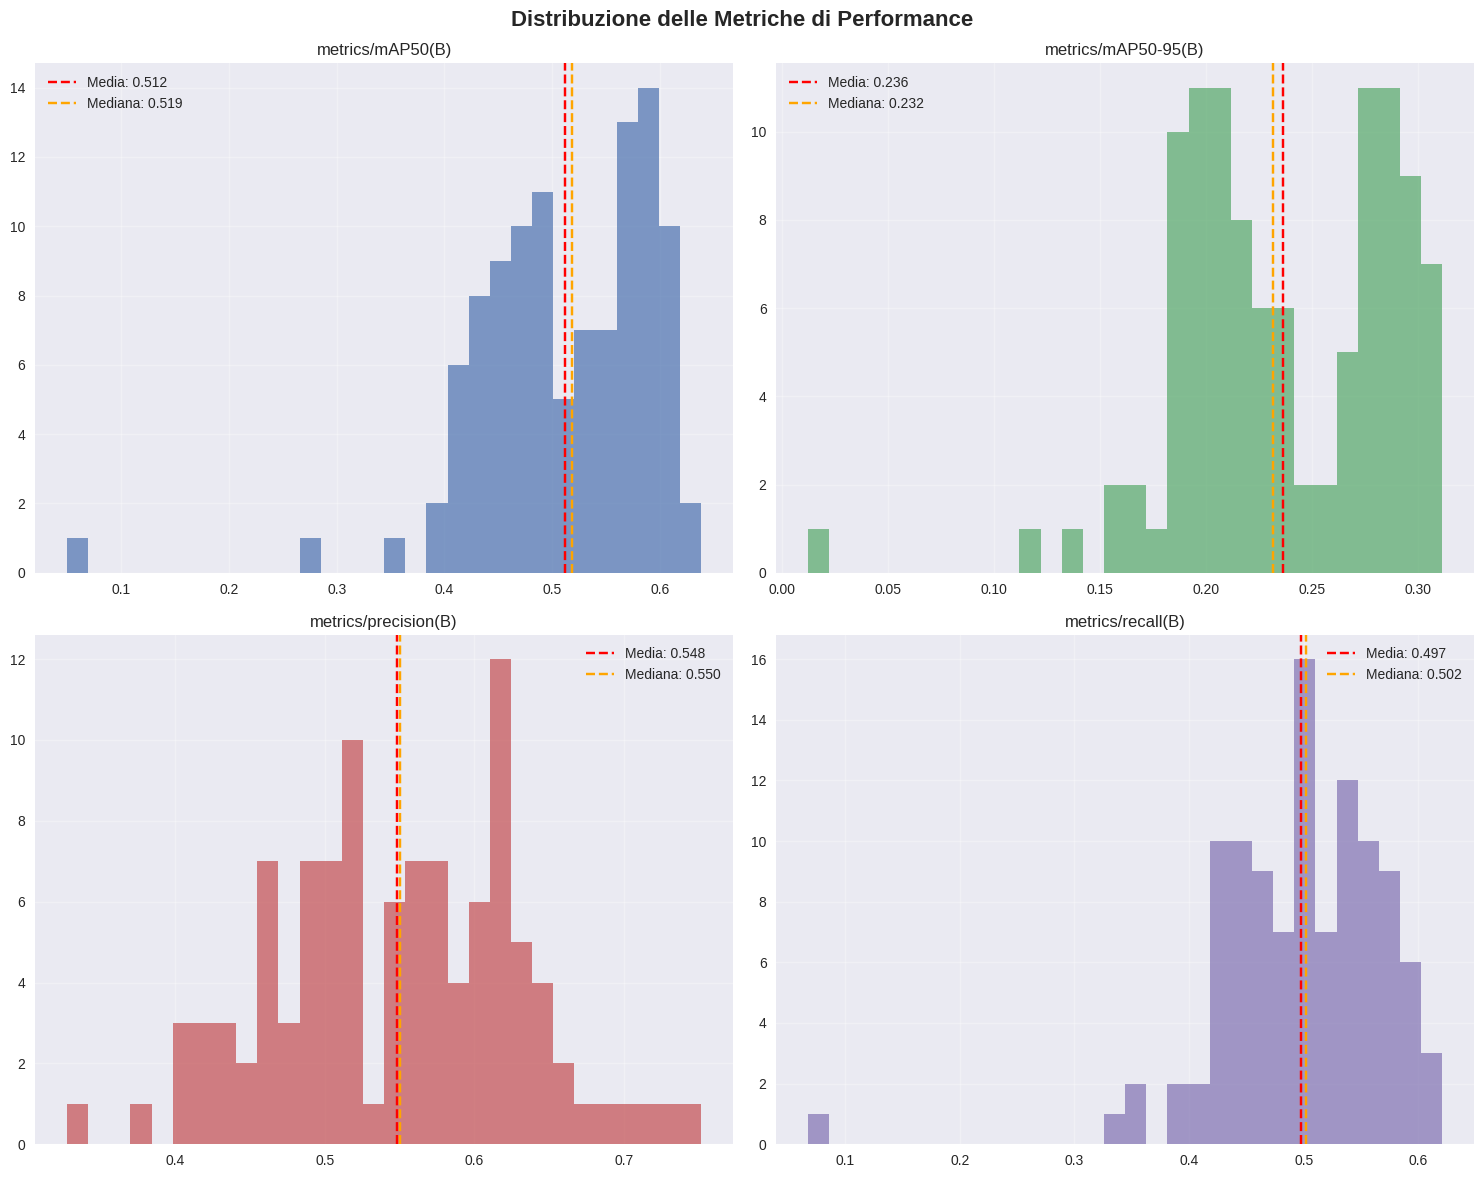

=== STATISTICHE METRICHE DI PERFORMANCE ===

metrics/mAP50(B):
  Media: 0.5118
  Mediana: 0.5188
  Std: 0.0835
  Min: 0.0497
  Max: 0.6385
  Q25: 0.4579
  Q75: 0.5773

metrics/mAP50-95(B):
  Media: 0.2362
  Mediana: 0.2316
  Std: 0.0513
  Min: 0.0121
  Max: 0.3114
  Q25: 0.1968
  Q75: 0.2822

metrics/precision(B):
  Media: 0.5484
  Mediana: 0.5504
  Std: 0.0820
  Min: 0.3274
  Max: 0.7517
  Q25: 0.4874
  Q75: 0.6149

metrics/recall(B):
  Media: 0.4973
  Mediana: 0.5017
  Std: 0.0735
  Min: 0.0675
  Max: 0.6210
  Q25: 0.4535
  Q75: 0.5493


In [5]:
# Distribuzione delle metriche principali
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribuzione delle Metriche di Performance', fontsize=16, fontweight='bold')

for i, metric in enumerate(available_performance[:4]):
    row, col = i // 2, i % 2
    
    # Istogramma
    axes[row, col].hist(df[metric].dropna(), bins=30, alpha=0.7, color=sns.color_palette()[i])
    axes[row, col].axvline(df[metric].mean(), color='red', linestyle='--', 
                          label=f'Media: {df[metric].mean():.3f}')
    axes[row, col].axvline(df[metric].median(), color='orange', linestyle='--', 
                          label=f'Mediana: {df[metric].median():.3f}')
    axes[row, col].set_title(f'{metric}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche dettagliate
print("=== STATISTICHE METRICHE DI PERFORMANCE ===")
for metric in available_performance:
    data = df[metric].dropna()
    print(f"\n{metric}:")
    print(f"  Media: {data.mean():.4f}")
    print(f"  Mediana: {data.median():.4f}")
    print(f"  Std: {data.std():.4f}")
    print(f"  Min: {data.min():.4f}")
    print(f"  Max: {data.max():.4f}")
    print(f"  Q25: {data.quantile(0.25):.4f}")
    print(f"  Q75: {data.quantile(0.75):.4f}")

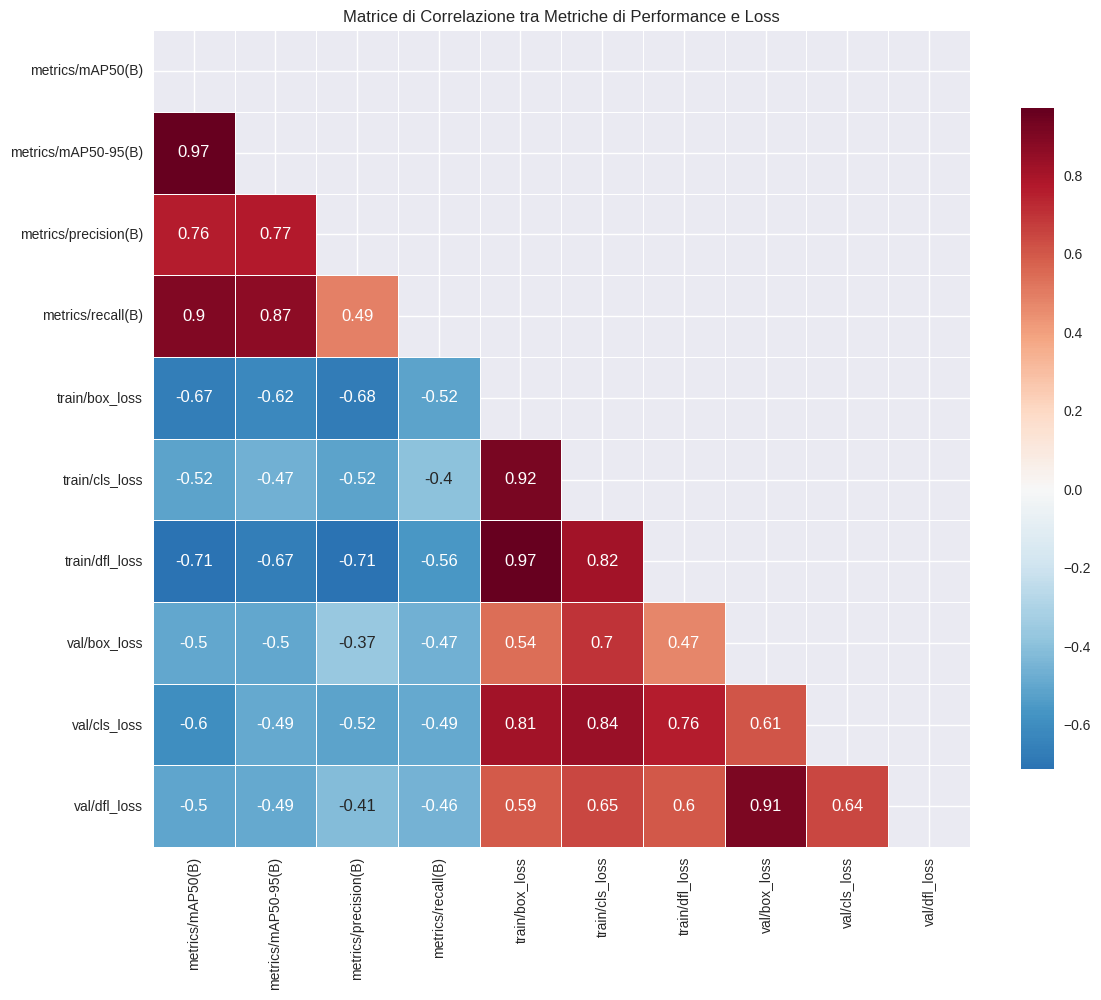

=== CORRELAZIONI PIÙ SIGNIFICATIVE ===
train/box_loss <-> train/dfl_loss: 0.971
metrics/mAP50(B) <-> metrics/mAP50-95(B): 0.967
train/box_loss <-> train/cls_loss: 0.916
val/box_loss <-> val/dfl_loss: 0.911
metrics/mAP50(B) <-> metrics/recall(B): 0.897
metrics/mAP50-95(B) <-> metrics/recall(B): 0.868
train/cls_loss <-> val/cls_loss: 0.837
train/cls_loss <-> train/dfl_loss: 0.815
train/box_loss <-> val/cls_loss: 0.813
metrics/mAP50-95(B) <-> metrics/precision(B): 0.771


In [6]:
# Matrice di correlazione tra tutte le metriche
all_metrics = available_performance + available_loss
correlation_matrix = df[all_metrics].corr()

# Heatmap delle correlazioni
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Matrice di Correlazione tra Metriche di Performance e Loss')
plt.tight_layout()
plt.show()

# Trova le correlazioni più forti
print("=== CORRELAZIONI PIÙ SIGNIFICATIVE ===")
corr_pairs = []
for i in range(len(all_metrics)):
    for j in range(i+1, len(all_metrics)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:  # Soglia per correlazioni significative
            corr_pairs.append((all_metrics[i], all_metrics[j], corr_val))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for metric1, metric2, corr in corr_pairs[:10]:
    print(f"{metric1} <-> {metric2}: {corr:.3f}")

In [7]:
# Definisci una metrica composita per ranking
def calculate_composite_score(row):
    """Calcola un punteggio composito basato su tutte le metriche"""
    score = 0
    
    # Aggiungi metriche positive (più alto = meglio)
    for metric in available_performance:
        if pd.notna(row[metric]):
            normalized_val = (row[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
            score += normalized_val
    
    # Sottrai metriche negative (più basso = meglio) 
    for metric in available_loss:
        if pd.notna(row[metric]):
            normalized_val = (row[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
            score -= normalized_val
    
    return score

df['composite_score'] = df.apply(calculate_composite_score, axis=1)

# Top 10 configurazioni
top_10 = df.nlargest(10, 'composite_score')
print("=== TOP 10 CONFIGURAZIONI ===")
print(top_10[['composite_score'] + available_performance + available_loss].round(4))

# Analisi dei top performer
print("\n=== CARATTERISTICHE DEI TOP PERFORMER ===")
top_5 = df.nlargest(5, 'composite_score')
for param in available_hyperparams[:10]:  # Primi 10 iperparametri
    if param in df.columns:
        print(f"\n{param}:")
        print(f"  Top 5 - Media: {top_5[param].mean():.4f}, Std: {top_5[param].std():.4f}")
        print(f"  Tutti - Media: {df[param].mean():.4f}, Std: {df[param].std():.4f}")

=== TOP 10 CONFIGURAZIONI ===
    composite_score  metrics/mAP50(B)  metrics/mAP50-95(B)  \
33           3.4885            0.6145               0.3114   
31           3.3557            0.6385               0.3086   
26           3.2790            0.6324               0.3049   
1            3.2679            0.6083               0.3045   
13           3.0746            0.5821               0.2899   
40           3.0691            0.5964               0.2846   
47           3.0562            0.6049               0.3001   
36           3.0485            0.6068               0.3082   
12           3.0372            0.6023               0.2765   
53           3.0170            0.5853               0.2842   

    metrics/precision(B)  metrics/recall(B)  train/box_loss  train/cls_loss  \
33                0.6610             0.6059          1.2910          0.9111   
31                0.7158             0.5336          1.3142          0.8771   
26                0.6726             0.5650       

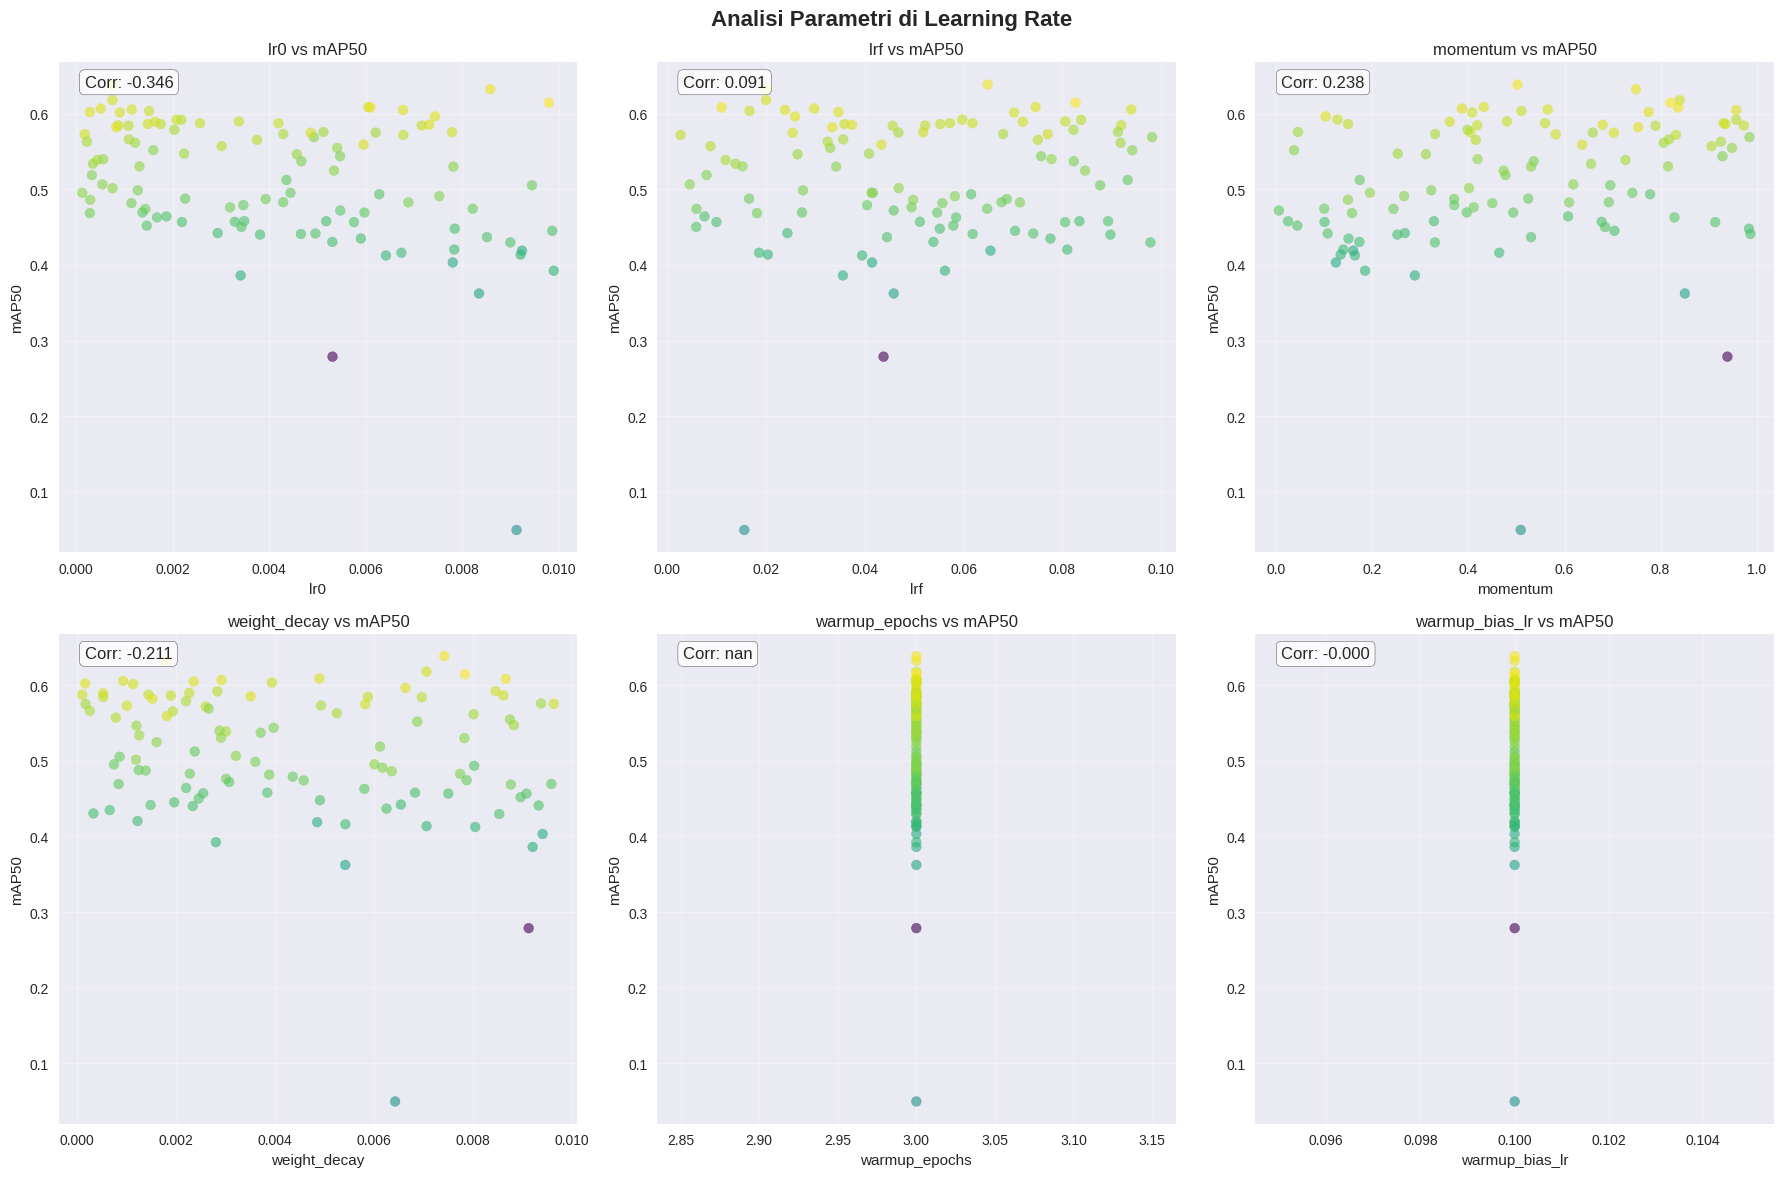

In [8]:
# Analisi dei learning rate parameters
lr_params = ['lr0', 'lrf', 'momentum', 'weight_decay', 'warmup_epochs', 'warmup_bias_lr']
available_lr_params = [p for p in lr_params if p in df.columns]

if available_lr_params:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Analisi Parametri di Learning Rate', fontsize=16, fontweight='bold')
    
    for i, param in enumerate(available_lr_params[:6]):
        row, col = i // 3, i % 3
        
        # Scatter plot con mAP50
        if 'metrics/mAP50(B)' in df.columns:
            scatter = axes[row, col].scatter(df[param], df['metrics/mAP50(B)'], 
                                           alpha=0.6, c=df['composite_score'], 
                                           cmap='viridis', s=50)
            axes[row, col].set_xlabel(param)
            axes[row, col].set_ylabel('mAP50')
            axes[row, col].set_title(f'{param} vs mAP50')
            axes[row, col].grid(True, alpha=0.3)
            
            # Calcola correlazione
            corr = df[param].corr(df['metrics/mAP50(B)'])
            axes[row, col].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                               transform=axes[row, col].transAxes, 
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

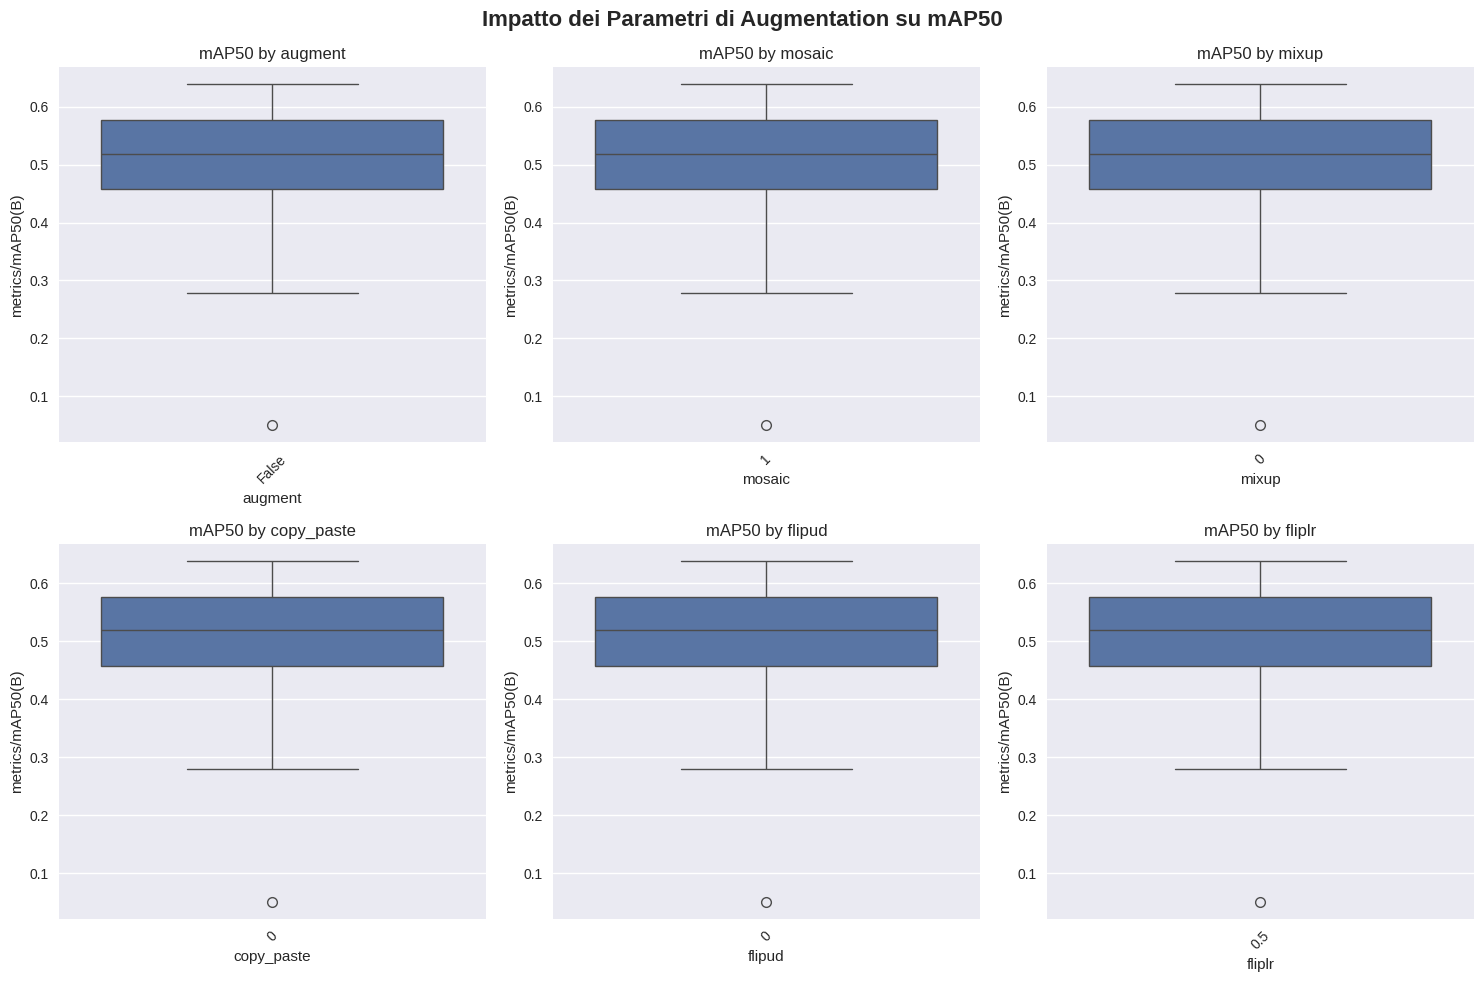

=== CORRELAZIONI PARAMETRI AUGMENTATION CON PERFORMANCE ===
degrees <-> mAP50: nan
translate <-> mAP50: -0.000
scale <-> mAP50: nan
shear <-> mAP50: nan
perspective <-> mAP50: nan
hsv_h <-> mAP50: 0.000
hsv_s <-> mAP50: 0.000
hsv_v <-> mAP50: -0.000
erasing <-> mAP50: -0.000
crop_fraction <-> mAP50: nan


In [9]:
# Parametri di data augmentation
aug_params = ['augment', 'mosaic', 'mixup', 'copy_paste', 'degrees', 'translate', 
              'scale', 'shear', 'perspective', 'hsv_h', 'hsv_s', 'hsv_v', 
              'flipud', 'fliplr', 'erasing', 'crop_fraction']
available_aug_params = [p for p in aug_params if p in df.columns]

# Box plot per parametri categorici di augmentation
categorical_aug = ['augment', 'mosaic', 'mixup', 'copy_paste', 'flipud', 'fliplr']
available_cat_aug = [p for p in categorical_aug if p in df.columns]

if available_cat_aug and 'metrics/mAP50(B)' in df.columns:
    n_plots = len(available_cat_aug)
    n_cols = 3
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Impatto dei Parametri di Augmentation su mAP50', fontsize=16, fontweight='bold')
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, param in enumerate(available_cat_aug):
        row, col = i // n_cols, i % n_cols
        
        try:
            sns.boxplot(data=df, x=param, y='metrics/mAP50(B)', ax=axes[row, col])
            axes[row, col].set_title(f'mAP50 by {param}')
            axes[row, col].tick_params(axis='x', rotation=45)
        except Exception as e:
            axes[row, col].text(0.5, 0.5, f'Errore: {param}', 
                               ha='center', va='center', transform=axes[row, col].transAxes)
    
    # Nascondi subplot vuoti
    for i in range(n_plots, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Analisi dei parametri numerici di augmentation
numeric_aug = ['degrees', 'translate', 'scale', 'shear', 'perspective', 
               'hsv_h', 'hsv_s', 'hsv_v', 'erasing', 'crop_fraction']
available_num_aug = [p for p in numeric_aug if p in df.columns]

print("=== CORRELAZIONI PARAMETRI AUGMENTATION CON PERFORMANCE ===")
for param in available_num_aug:
    if 'metrics/mAP50(B)' in df.columns:
        corr = df[param].corr(df['metrics/mAP50(B)'])
        print(f"{param} <-> mAP50: {corr:.3f}")

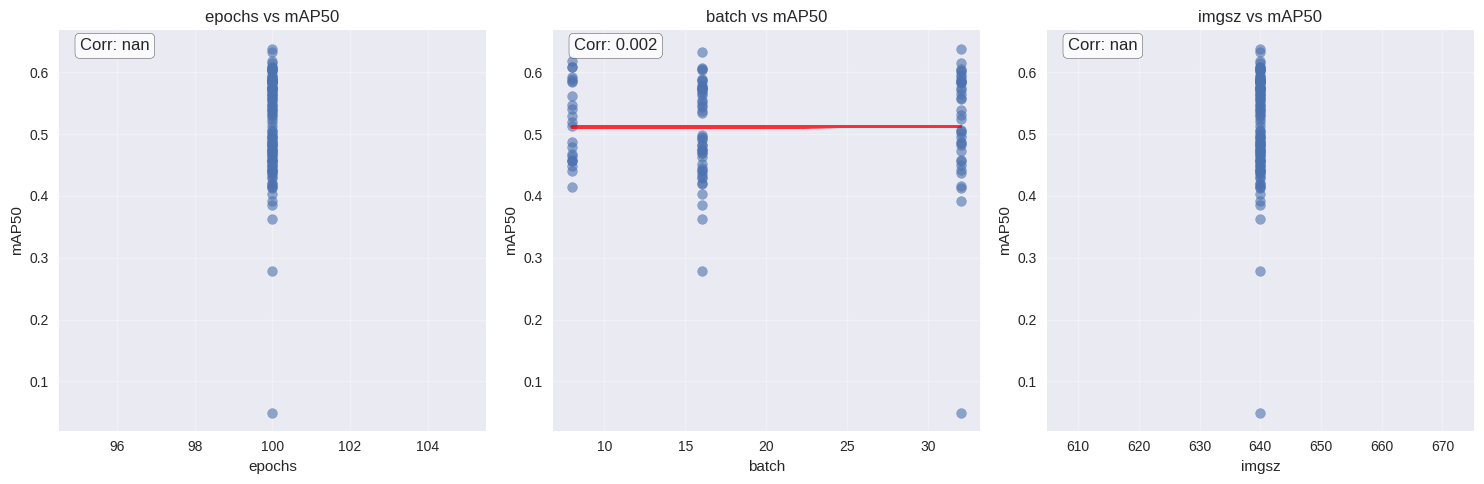

=== TRADE-OFF PERFORMANCE vs COMPLESSITÀ ===
model/GFLOPs <-> mAP50: 0.082
model/parameters <-> mAP50: -0.082
model/speed_PyTorch(ms) <-> mAP50: -0.184


In [10]:
# Parametri di architettura e training
model_params = ['epochs', 'batch', 'imgsz']
available_model_params = [p for p in model_params if p in df.columns]

if available_model_params:
    fig, axes = plt.subplots(1, len(available_model_params), figsize=(5*len(available_model_params), 5))
    if len(available_model_params) == 1:
        axes = [axes]
    
    for i, param in enumerate(available_model_params):
        if 'metrics/mAP50(B)' in df.columns:
            # Scatter plot con trend line
            x = df[param].dropna()
            y = df['metrics/mAP50(B)'][df[param].notna()]
            
            axes[i].scatter(x, y, alpha=0.6, s=50)
            
            # Aggiungi trend line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            axes[i].plot(x, p(x), "r--", alpha=0.8)
            
            axes[i].set_xlabel(param)
            axes[i].set_ylabel('mAP50')
            axes[i].set_title(f'{param} vs mAP50')
            axes[i].grid(True, alpha=0.3)
            
            # Correlazione
            corr = df[param].corr(df['metrics/mAP50(B)'])
            axes[i].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                        transform=axes[i].transAxes,
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Analisi delle dimensioni del modello e velocità
model_metrics = ['model/GFLOPs', 'model/parameters', 'model/speed_PyTorch(ms)']
available_model_metrics = [m for m in model_metrics if m in df.columns]

if available_model_metrics:
    print("=== TRADE-OFF PERFORMANCE vs COMPLESSITÀ ===")
    for metric in available_model_metrics:
        if 'metrics/mAP50(B)' in df.columns:
            corr = df[metric].corr(df['metrics/mAP50(B)'])
            print(f"{metric} <-> mAP50: {corr:.3f}")

=== ANALISI DEI CLUSTER ===

Cluster 0 (n=15):
  mAP50 medio: 0.5255
  mAP50 std: 0.0596
  Composite Score medio: 2.1245
  Caratteristiche principali:
    lr0: 0.002 (vs globale: 0.004)
    lrf: 0.067 (vs globale: 0.051)
    momentum: 0.272 (vs globale: 0.508)
    weight_decay: 0.004 (vs globale: 0.004)

Cluster 1 (n=17):
  mAP50 medio: 0.5559
  mAP50 std: 0.0551
  Composite Score medio: 2.5432
  Caratteristiche principali:
    lr0: 0.004 (vs globale: 0.004)
    lrf: 0.026 (vs globale: 0.051)
    momentum: 0.781 (vs globale: 0.508)
    weight_decay: 0.003 (vs globale: 0.004)

Cluster 2 (n=25):
  mAP50 medio: 0.4610
  mAP50 std: 0.1208
  Composite Score medio: 1.2858
  Caratteristiche principali:
    lr0: 0.007 (vs globale: 0.004)
    weight_decay: 0.007 (vs globale: 0.004)

Cluster 3 (n=21):
  mAP50 medio: 0.5078
  mAP50 std: 0.0624
  Composite Score medio: 1.8367
  Caratteristiche principali:
    lr0: 0.002 (vs globale: 0.004)
    lrf: 0.027 (vs globale: 0.051)
    momentum: 0.443 (vs

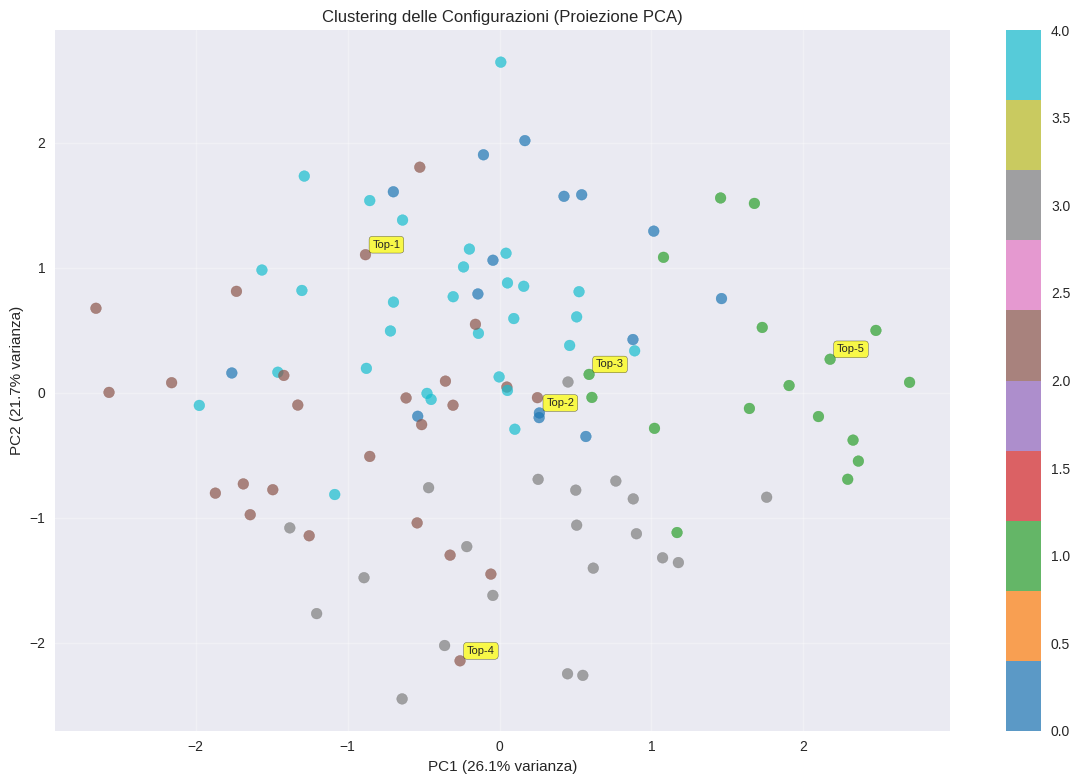

In [11]:
# Prepara i dati per clustering
cluster_features = available_hyperparams[:15]  # Usa i primi 15 iperparametri
cluster_data = df[cluster_features].fillna(df[cluster_features].mean())

# Standardizza i dati
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Applica K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Analizza i cluster
print("=== ANALISI DEI CLUSTER ===")
for cluster_id in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    
    if 'metrics/mAP50(B)' in df.columns:
        print(f"  mAP50 medio: {cluster_data['metrics/mAP50(B)'].mean():.4f}")
        print(f"  mAP50 std: {cluster_data['metrics/mAP50(B)'].std():.4f}")
    
    print(f"  Composite Score medio: {cluster_data['composite_score'].mean():.4f}")
    
    # Caratteristiche distintive del cluster
    print("  Caratteristiche principali:")
    for param in cluster_features[:5]:
        mean_val = cluster_data[param].mean()
        global_mean = df[param].mean()
        if abs(mean_val - global_mean) > 0.1 * df[param].std():
            print(f"    {param}: {mean_val:.3f} (vs globale: {global_mean:.3f})")

# Visualizza i cluster con PCA
pca = PCA(n_components=2)
cluster_pca = pca.fit_transform(cluster_data_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(cluster_pca[:, 0], cluster_pca[:, 1], 
                     c=df['cluster'], cmap='tab10', alpha=0.7, s=60)
plt.colorbar(scatter)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.title('Clustering delle Configurazioni (Proiezione PCA)')
plt.grid(True, alpha=0.3)

# Aggiungi etichette per i top performer
top_5_indices = df.nlargest(5, 'composite_score').index
for idx in top_5_indices:
    plt.annotate(f'Top-{list(top_5_indices).index(idx)+1}', 
                xy=(cluster_pca[idx, 0], cluster_pca[idx, 1]),
                xytext=(5, 5), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                fontsize=8)

plt.tight_layout()
plt.show()

0.0098990984374759
0.0981443226207957
0.987281463463806
0.0096332925575265
3
0.1
7.5
0.5
1.5
100
32
640
False
1
0
0
0
0.1
0.5
0
0
0.015
0.7
0.4
0
0.5
0.4
1


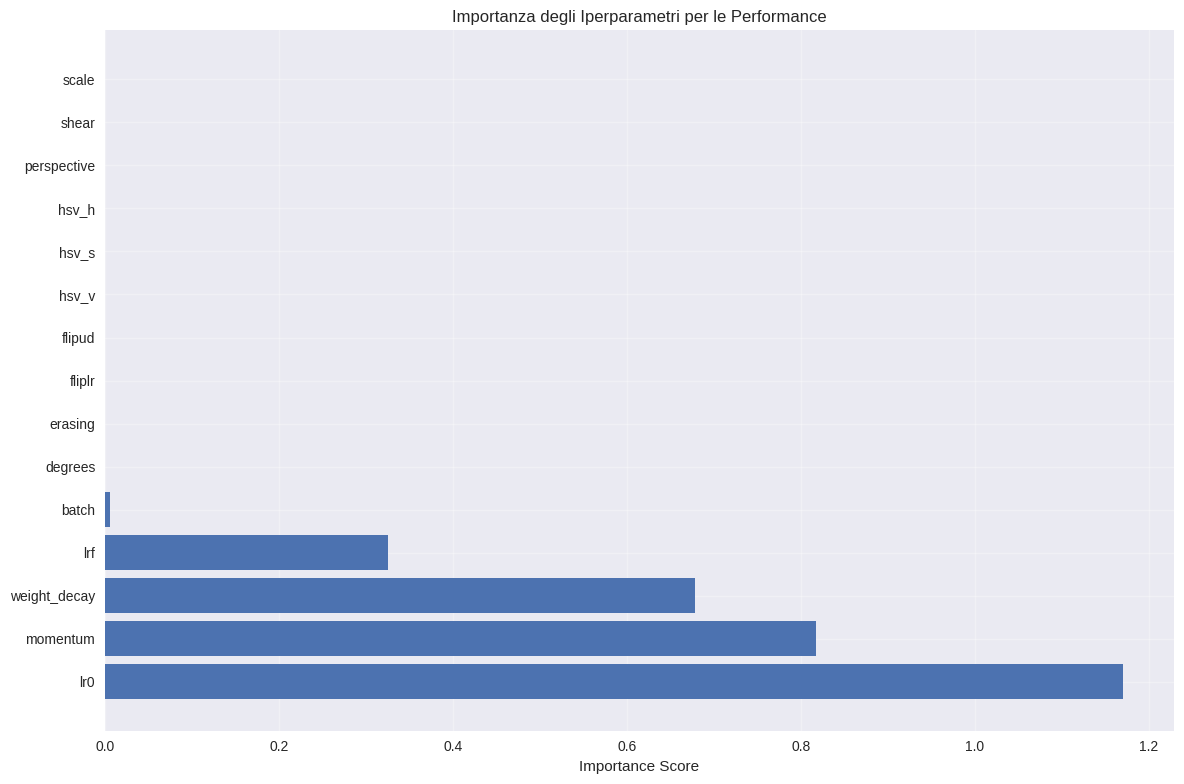

=== RANKING IMPORTANZA IPERPARAMETRI ===
 1. lr0: 1.1702
 2. momentum: 0.8177
 3. weight_decay: 0.6783
 4. lrf: 0.3258
 5. batch: 0.0061
 6. degrees: 0.0000
 7. erasing: 0.0000
 8. fliplr: 0.0000
 9. flipud: 0.0000
10. hsv_v: 0.0000


In [14]:
# Calcola l'importanza degli iperparametri basata sulla varianza delle performance
def calculate_hyperparameter_importance():
    importance_scores = {}
    
    for param in available_hyperparams:
        if param in df.columns and 'metrics/mAP50(B)' in df.columns:
            # Calcola la correlazione assoluta
            corr = abs(df[param].corr(df['metrics/mAP50(B)']))
            
            # Calcola l'effetto della variazione del parametro
            param_std = df[param].std()
            print(df[param].max())
            param_range = df[param].max() - df[param].min() if df[param].max() and df[param].min() else 0
            
            # Score combinato
            importance_scores[param] = corr * (param_range / param_std) if param_std > 0 else 0
    
    return importance_scores

importance = calculate_hyperparameter_importance()
importance_df = pd.DataFrame(list(importance.items()), 
                           columns=['Parameter', 'Importance']).sort_values('Importance', ascending=False)

# Visualizza l'importanza degli iperparametri
plt.figure(figsize=(12, 8))
top_params = importance_df.head(15)
plt.barh(range(len(top_params)), top_params['Importance'])
plt.yticks(range(len(top_params)), top_params['Parameter'])
plt.xlabel('Importance Score')
plt.title('Importanza degli Iperparametri per le Performance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=== RANKING IMPORTANZA IPERPARAMETRI ===")
for i, (param, score) in enumerate(importance_df.head(10).values):
    print(f"{i+1:2d}. {param}: {score:.4f}")

In [15]:
# Identifica la configurazione ottimale
best_config = df.loc[df['composite_score'].idxmax()]

print("="*60)
print("🎯 CONFIGURAZIONE OTTIMALE IDENTIFICATA")
print("="*60)

print(f"Composite Score: {best_config['composite_score']:.4f}")
print(f"Run ID: {best_config.get('run_id', 'N/A')}")

print("\n📊 METRICHE DI PERFORMANCE:")
for metric in available_performance:
    print(f"  {metric}: {best_config[metric]:.4f}")

print("\n📉 LOSS VALUES:")
for metric in available_loss:
    print(f"  {metric}: {best_config[metric]:.4f}")

print("\n⚙️ IPERPARAMETRI CHIAVE:")
important_params = importance_df.head(10)['Parameter'].values
for param in important_params:
    if param in df.columns:
        print(f"  {param}: {best_config[param]}")

# Confronta con la media
print("\n" + "="*60)
print("📈 CONFRONTO CON LA MEDIA DEL DATASET")
print("="*60)

for metric in available_performance:
    improvement = ((best_config[metric] - df[metric].mean()) / df[metric].mean()) * 100
    print(f"{metric}: {improvement:+.2f}% rispetto alla media")

# Analisi di robustezza
print("\n" + "="*60)
print("🔍 ANALISI DI ROBUSTEZZA")
print("="*60)

# Trova configurazioni simili alla migliore
similarity_threshold = 0.8
similar_configs = []

for idx, row in df.iterrows():
    if idx != df['composite_score'].idxmax():
        similarity = 0
        count = 0
        for param in important_params[:5]:  # Usa i 5 parametri più importanti
            if param in df.columns:
                if abs(row[param] - best_config[param]) / (df[param].std() + 1e-6) < 1:
                    similarity += 1
                count += 1
        
        if count > 0 and similarity / count >= similarity_threshold:
            similar_configs.append((idx, row['composite_score']))

if similar_configs:
    print(f"Trovate {len(similar_configs)} configurazioni simili con performance comparabili")
    similar_scores = [score for _, score in similar_configs]
    print(f"Score medio configurazioni simili: {np.mean(similar_scores):.4f}")
    print(f"Deviazione standard: {np.std(similar_scores):.4f}")
else:
    print("⚠️  La configurazione ottimale è unica - potrebbe essere overfitting")

# Raccomandazioni finali
print("\n" + "="*60)
print("💡 RACCOMANDAZIONI FINALI")
print("="*60)

print("1. CONFIGURAZIONE RACCOMANDATA:")
print("   Usa la configurazione ottimale identificata sopra")

print("\n2. PARAMETRI CRITICI DA MONITORARE:")
for i, param in enumerate(important_params[:5]):
    print(f"   {i+1}. {param}")

print("\n3. SUGGERIMENTI PER ULTERIORI ESPERIMENTI:")
print("   - Fai fine-tuning attorno ai valori ottimali identificati")
print("   - Testa combinazioni degli iperparametri più importanti")
print("   - Considera l'early stopping se non già implementato")

if len(similar_configs) < 3:
    print("   - Aumenta il numero di esperimenti per validare la robustezza")

print("\n4. TRADE-OFF DA CONSIDERARE:")
if 'model/speed_PyTorch(ms)' in df.columns:
    speed_corr = df['model/speed_PyTorch(ms)'].corr(df['metrics/mAP50(B)'])
    if speed_corr > 0.3:
        print("   - Performance vs Velocità di inferenza (correlazione positiva)")
    elif speed_corr < -0.3:
        print("   - Performance vs Velocità di inferenza (correlazione negativa)")

if 'model/parameters' in df.columns:
    param_corr = df['model/parameters'].corr(df['metrics/mAP50(B)'])
    if param_corr > 0.3:
        print("   - Performance vs Dimensione modello (più parametri = migliori performance)")
    elif param_corr < -0.3:
        print("   - Performance vs Dimensione modello (meno parametri = migliori performance)")

print("\n" + "="*60)
print("✅ ANALISI COMPLETATA")
print("="*60)

🎯 CONFIGURAZIONE OTTIMALE IDENTIFICATA
Composite Score: 3.4885
Run ID: 1ts1d6um

📊 METRICHE DI PERFORMANCE:
  metrics/mAP50(B): 0.6145
  metrics/mAP50-95(B): 0.3114
  metrics/precision(B): 0.6610
  metrics/recall(B): 0.6059

📉 LOSS VALUES:
  train/box_loss: 1.2910
  train/cls_loss: 0.9111
  train/dfl_loss: 1.1098
  val/box_loss: 1.9817
  val/cls_loss: 1.6511
  val/dfl_loss: 1.5086

⚙️ IPERPARAMETRI CHIAVE:
  lr0: 0.009799360489695
  momentum: 0.8206979179968263
  weight_decay: 0.007840277810131
  lrf: 0.0826529546355827
  batch: 32
  degrees: 0
  erasing: 0.4
  fliplr: 0.5
  flipud: 0
  hsv_v: 0.4

📈 CONFRONTO CON LA MEDIA DEL DATASET
metrics/mAP50(B): +20.07% rispetto alla media
metrics/mAP50-95(B): +31.83% rispetto alla media
metrics/precision(B): +20.54% rispetto alla media
metrics/recall(B): +21.83% rispetto alla media

🔍 ANALISI DI ROBUSTEZZA
Trovate 1 configurazioni simili con performance comparabili
Score medio configurazioni simili: 1.6072
Deviazione standard: 0.0000

💡 RACCOMA

In [16]:
# Salva i risultati dell'analisi
results_summary = {
    'best_config_index': df['composite_score'].idxmax(),
    'best_composite_score': df['composite_score'].max(),
    'hyperparameter_importance': importance_df.head(10).to_dict(),
    'top_10_configs': top_10[available_performance + available_loss + ['composite_score']].to_dict(),
    'cluster_analysis': df.groupby('cluster')['composite_score'].agg(['mean', 'std', 'count']).to_dict()
}

# Salva la configurazione ottimale in un file separato
optimal_config = best_config[available_hyperparams].to_dict()

print("💾 Per salvare i risultati, decommenta le righe seguenti:")
print("# import json")
print("# with open('yolo_eda_results.json', 'w') as f:")
print("#     json.dump(results_summary, f, indent=2)")
print("# ")
print("# with open('optimal_yolo_config.json', 'w') as f:")
print("#     json.dump(optimal_config, f, indent=2)")

print("\n🎉 EDA completata! Usa le raccomandazioni sopra per ottimizzare il tuo modello YOLO.")

💾 Per salvare i risultati, decommenta le righe seguenti:
# import json
# with open('yolo_eda_results.json', 'w') as f:
#     json.dump(results_summary, f, indent=2)
# 
# with open('optimal_yolo_config.json', 'w') as f:
#     json.dump(optimal_config, f, indent=2)

🎉 EDA completata! Usa le raccomandazioni sopra per ottimizzare il tuo modello YOLO.
